## Setup, Loading Data and CDFs

In [4]:
DATA_NAME = 'ravdess-1e5rawre' #dataset-compression
TRANSFORM = 'erb-male' #transform-group
CHANNEL = ''
NUM_BANDS = int(10)

In [5]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
male_erb_1e5rawre_ravdess.ipynb


In [6]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results-audio", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'band' 
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'e:\\Research\\UCB\\Strang Lab\\Github\\hierarchical-bayesian-model-validation\\results-audio\\case-studies\\ravdess\\1e5rawre\\erb\\male'

In [7]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [8]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}-size.pickle'))

In [9]:
if 'erb' in TRANSFORM:
    group_data_map.popitem()
NUM_BANDS = max(min(NUM_BANDS, len(group_data_map) - 2), 1)

In [10]:
#if 'fourier' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
#elif 'wavelet' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)
#GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::max(len(group_data_map) // NUM_BANDS, 1)]
GROUPS = np.linspace(2, sorted(group_data_map)[-1], NUM_BANDS, dtype=int)


cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
#group_total_samples
#group_data_map


Running 12760 CDFs


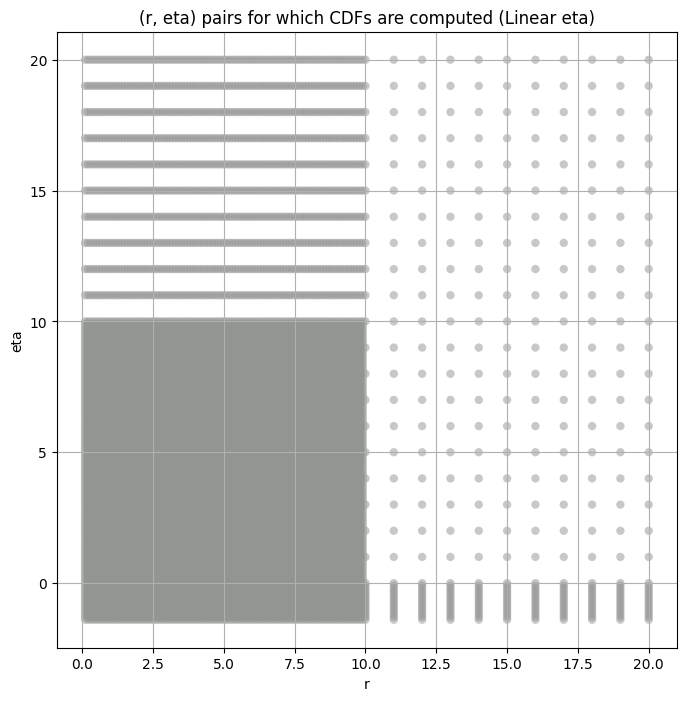

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [11]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [12]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [13]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 11


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 12


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 14


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 16


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var  var_lower  var_upper    obs_kurt  kurt_lower  kurt_upper  \
band                                                                       
2     0.029489   0.023873   0.036184   62.912878   39.554258   92.925360   
3     0.456956   0.403068   0.515163   20.634428   17.347091   24.231608   
5     2.054075   1.901039   2.211808    6.690379    5.783197    7.695582   
6     1.437103   1.323974   1.553742    7.705143    6.794343    8.683341   
8     0.119230   0.105100   0.135650   22.735538   14.230040   38.649732   
9     0.038668   0.034168   0.044289   22.991529   12.297513   58.716762   
11    0.017660   0.014538   0.021348   52.619247   33.954769   94.025944   
12    0.005025   0.003985   0.006606   93.957778   41.206982  280.084258   
14    0.000343   0.000266   0.000455  107.904099   46.007350  303.776315   
16    0.000089   0.000058   0.000144  337.955866  110.806686  914.250102   

      total_samples  
band                 
2           98098.0  
3          109212.0  
5         1081864.0  
6          546468.0  
8         3541926.0  
9         5314425.0  
11        6734585.0  
12       22178309.0  
14       12486961.0  
16        8165465.0

## Initial Grid Search and Hypothesis Test Plots

In [14]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [15]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  var_exclude_75  \
band                                                                            
2     0.029489       0.029489        0.025947        0.023690        0.022036   
3     0.456956       0.456956        0.436798        0.421300        0.407640   
5     2.054075       2.054075        2.011027        1.976985        1.946531   
6     1.437103       1.437103        1.407252        1.382589        1.360389   
8     0.119230       0.119230        0.111339        0.106835        0.103291   
9     0.038668       0.038668        0.036095        0.034759        0.033725   
11    0.017660       0.017660        0.015862        0.014828        0.014018   
12    0.005025       0.005025        0.004333        0.004000        0.003747   
14    0.000343       0.000343        0.000290        0.000265        0.000247   
16    0.000089       0.000089        0.000064        0.000054        0.000047   

      var_exclude_100  var_exclude_150  var_exclude_200  var_exclude_250  \
band                                                                       
2            0.020777         0.018913         0.017481         0.016364   
3            0.395546         0.374010         0.355360         0.338869   
5            1.918395         1.867582         1.821988         1.780253   
6            1.339967         1.302991         1.269738         1.239148   
8            0.100311         0.095375         0.091351         0.087924   
9            0.032860         0.031433         0.030258         0.029244   
11           0.013340         0.012230         0.011332         0.010577   
12           0.003540         0.003208         0.002946         0.002730   
14           0.000232         0.000209         0.000191         0.000176   
16           0.000042         0.000034         0.000029         0.000025   

      var_exclude_300  var_exclude_350  var_exclude_500  
band                                                     
2            0.015468         0.014734         0.013084  
3            0.323915         0.310353         0.276518  
5            1.741624         1.705587         1.609516  
6            1.210610         1.183826         1.111605  
8            0.084929         0.082256         0.075611  
9            0.028345         0.027535         0.025476  
11           0.009927         0.009356         0.007987  
12           0.002547         0.002388         0.002013  
14           0.000163         0.000153         0.000128  
16           0.000022         0.000020         0.000015

####
Band  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.008325026589755424 0.02948862121047605


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.006211026315595003 0.02594719419978079


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.003999581286139975 0.023689793720853038


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.004936801123248014 0.02203587370513397


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.003825021906840531 0.02077743663867458


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.0037280477780469168 0.018913163765309774


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.003144845724073808 0.01748131208581403


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.003724863110466361 0.01636370325609879


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.004466961121089463 0.01546814931924455


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.005035998959406514 0.014734306848442565


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.0068641086124959765 0.01308413114180334
Number of samples: 100000, Without approximation : 98098.0


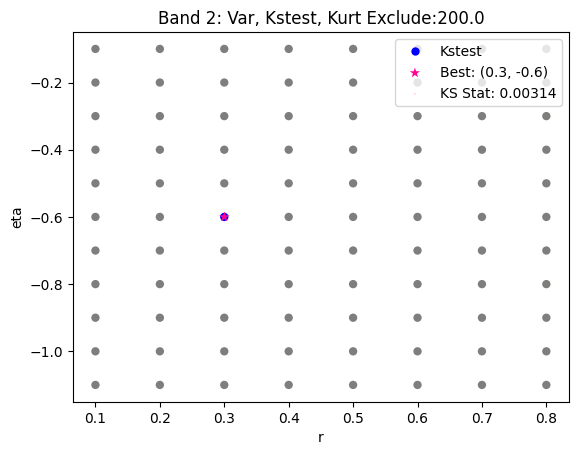

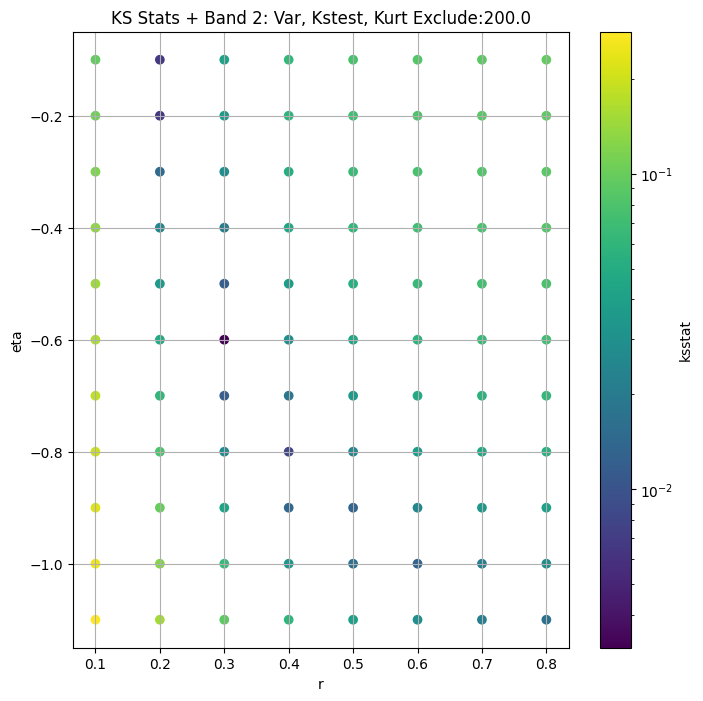

####
Band  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.015146871221285566 0.45695630881276766


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.016405141863329135 0.4367982935231229


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.0174018391808642 0.4213004072908535


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.018299759440651972 0.40764048686220367


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.019110702490263712 0.395546000550584


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.020714985401395263 0.3740103277717379


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.022181608356627497 0.3553597051743786


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.02139578381458218 0.33886908082729494


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.020157819021462617 0.32391473687293026


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.02134651234891316 0.3103526581363561


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.019682160144689494 0.2765183669650003
Number of samples: 100000, Without approximation : 109212.0


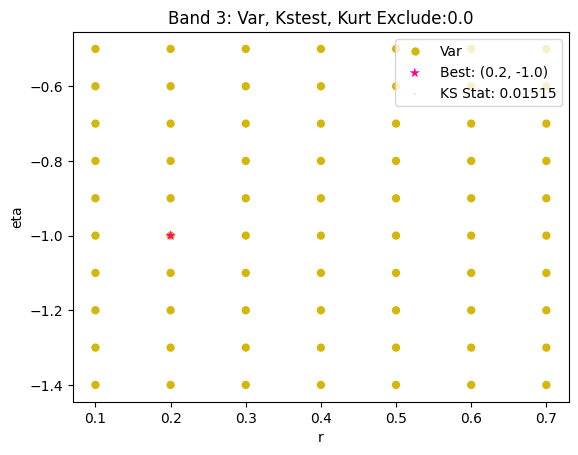

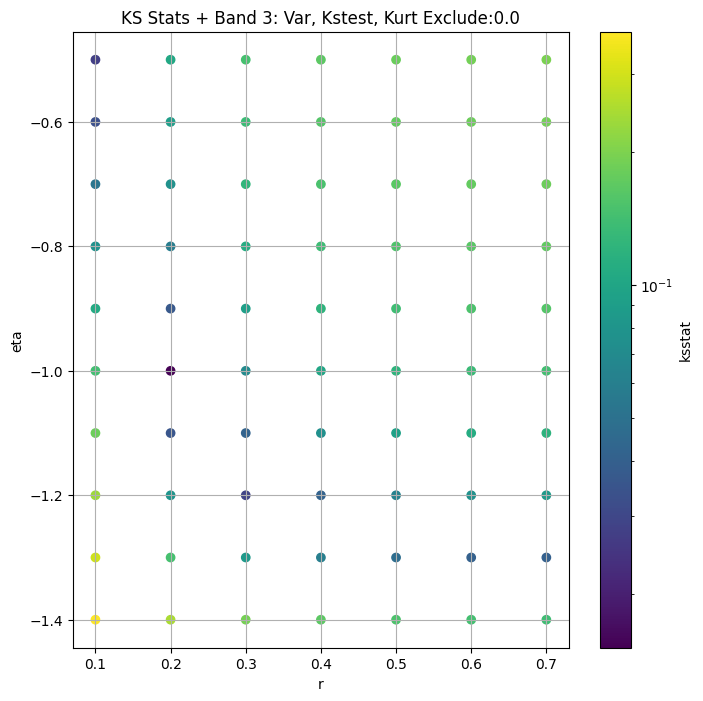

####
Band  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.009311160202178245 2.0540750755858106


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.00878018211290632 2.011026561682566


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.007948442384945742 1.9769853714919237


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.007433423204942141 1.946530865178164


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.008157840898487173 1.9183948586041608


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.009025313028047988 1.8675817852407253


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.009043065251291671 1.8219879931549874


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.008968019771811775 1.7802526830723822


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.008833405451240672 1.7416235972840979


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.008801071197630128 1.7055869019726895


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.00869747478241878 1.6095156695203579
Number of samples: 100000, Without approximation : 1081864.0


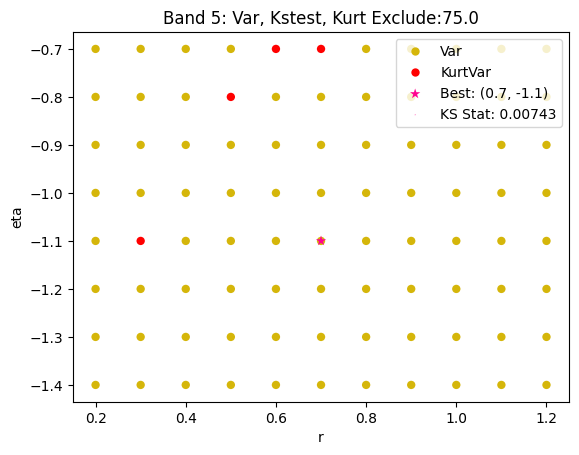

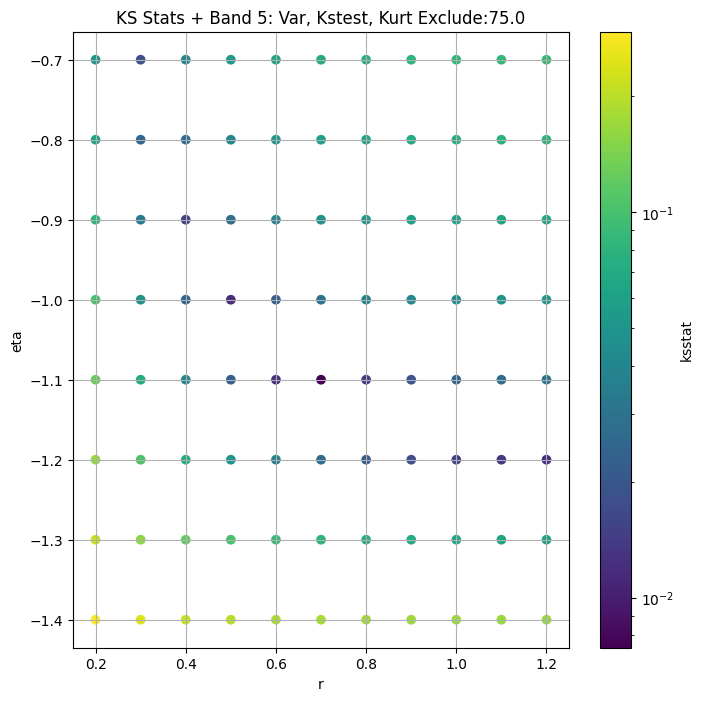

####
Band  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.011152980074323693 1.4371025797221268


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.011577394089857307 1.4072519565930828


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.010838060251345039 1.3825887301017554


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.009989786273831514 1.3603888775505502


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.009214138921397885 1.3399669214809344


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.01011145814356302 1.3029909572749288


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.01105430804541637 1.2697384003232244


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.011939241999939877 1.2391483245363506


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.011466973041419637 1.2106101183011182


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.011879344942547429 1.1838262360960552


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.01299938884169316 1.1116045716509169
Number of samples: 100000, Without approximation : 546468.0


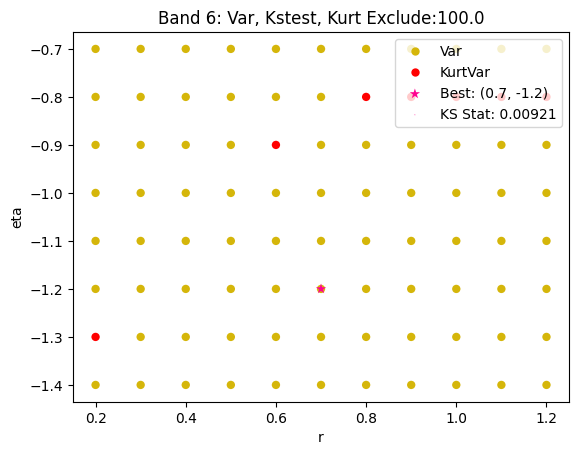

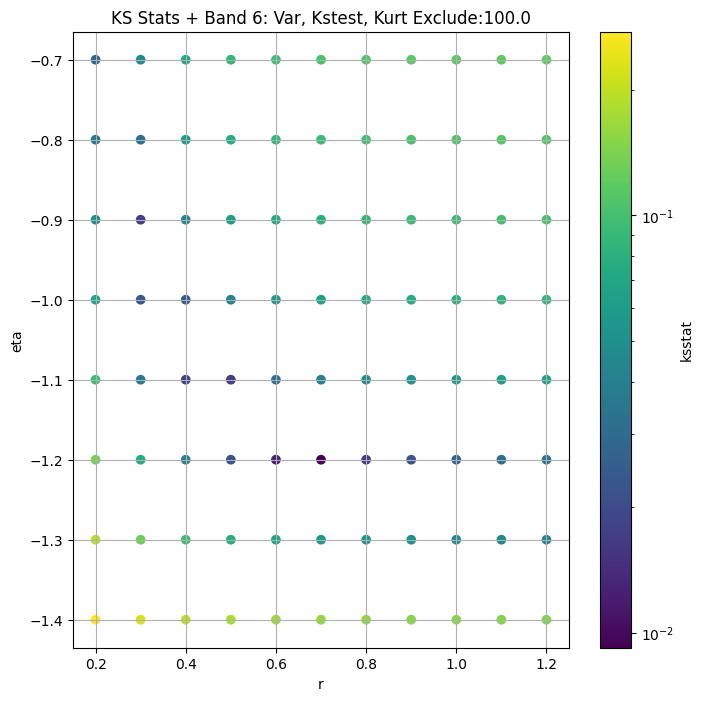

####
Band  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.0034198273313124083 0.11923045292271141


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.004350948088169271 0.11133899084102164


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.005778244880095887 0.106835268566401


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.0072385802876955285 0.10329052194247605


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.00699284646819287 0.10031080430851871


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.0040432432927272055 0.09537543075450108


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.005141630975321124 0.09135090750137853


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.006974436444984661 0.08792449811005024


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.007553212737664294 0.08492925263883541


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.006900479788121097 0.08225582290769286


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.008836679550027003 0.07561078901799556
Number of samples: 100000, Without approximation : 3541926.0


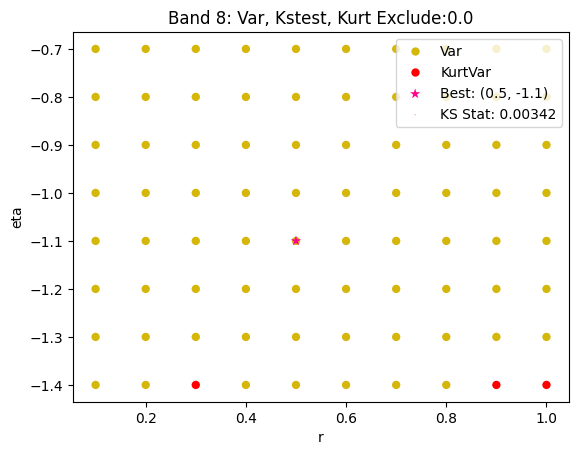

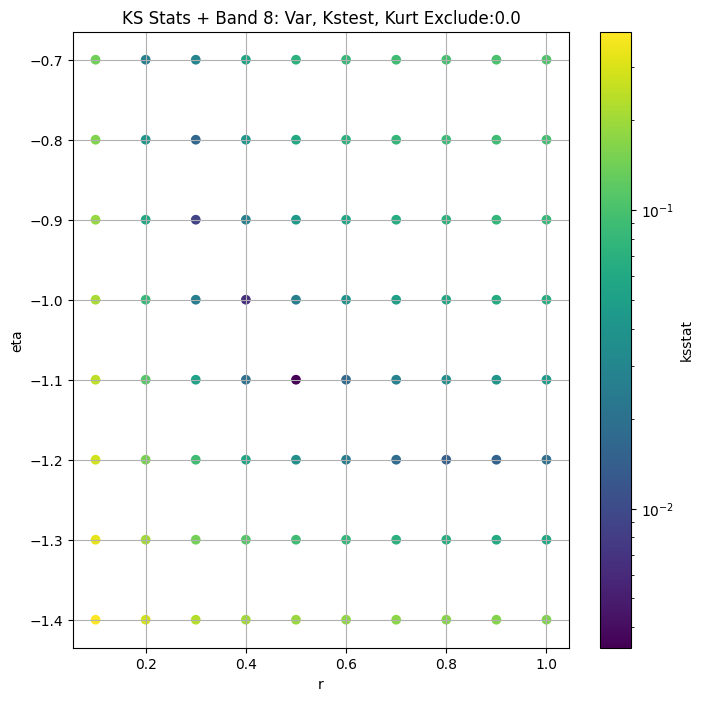

####
Band  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.003448199733523838 0.03866770635377723


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.0028333136541936615 0.03609527512608224


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.004898049657862127 0.034758767239025545


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.006578169525918373 0.03372472991280935


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.008037252306550169 0.03285994559082227


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.006952367389938763 0.03143318850480161


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.005824926767552814 0.030258037445911677


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.007270976223897295 0.029243688430219406


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.008682473716797923 0.028345157886862083


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.009467363736058665 0.02753500888885389


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.009245671797409927 0.025476458560708497
Number of samples: 100000, Without approximation : 5314425.0


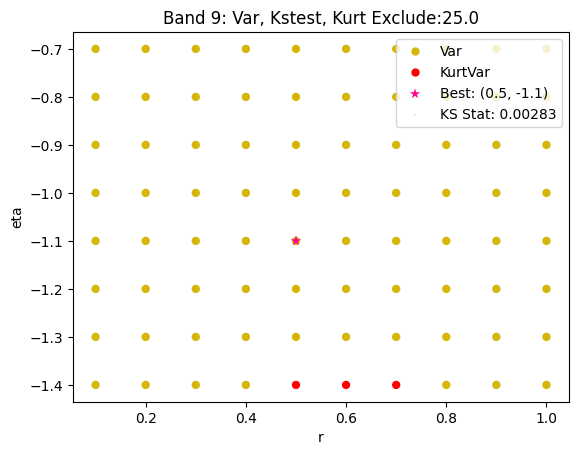

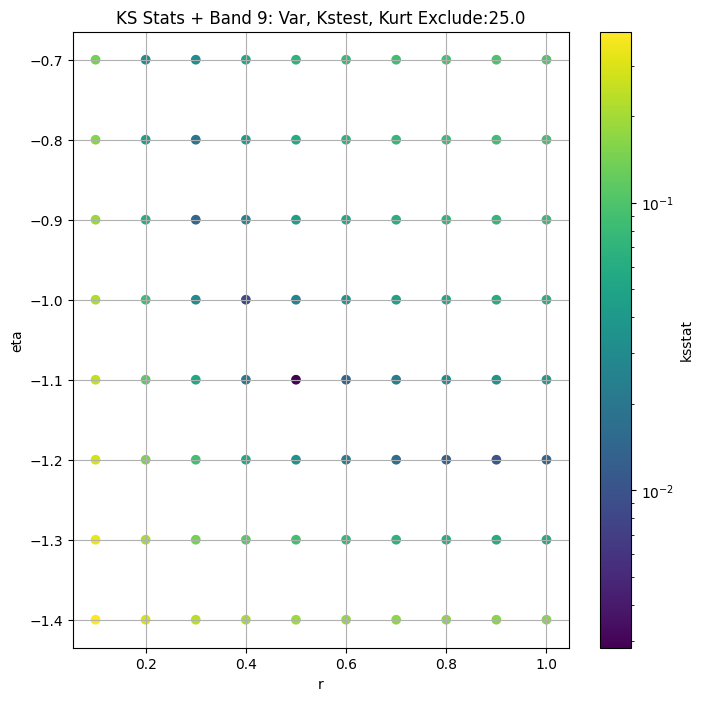

####
Band  11


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 0 0.006928074391706507 0.017660436665729196


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 25 0.006856355814573174 0.015861594498927788


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 50 0.008678302802866411 0.014827529534539483


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 75 0.01038335667826732 0.014018005497719107


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 100 0.008423413363993396 0.01333994763835071


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 150 0.010745253057551515 0.012229904704105104


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 200 0.013013572770174564 0.011331516238416784


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 250 0.011320610620887295 0.010576589971414233


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 300 0.00849481886935181 0.009926745440255088


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 350 0.00971997475032221 0.009356109427950891


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 500 0.013602889022290413 0.007986764360326254
Number of samples: 100000, Without approximation : 6734585.0


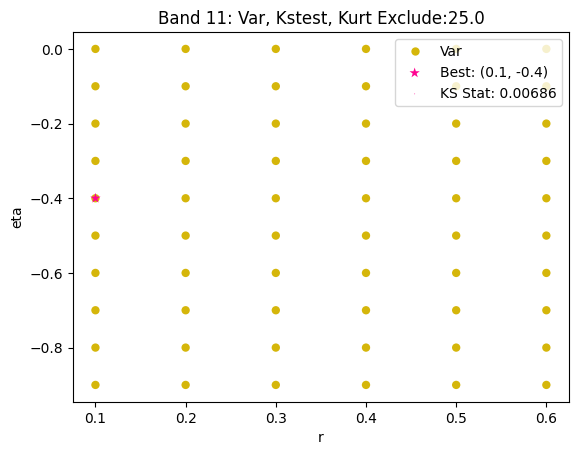

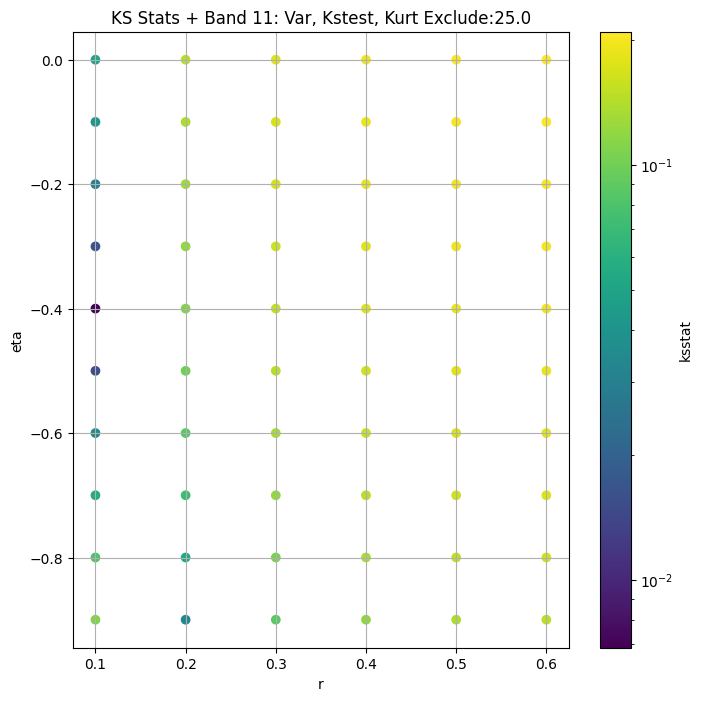

####
Band  12


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 0 0.011626879969789616 0.005025361482475439


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 25 0.00458952348956454 0.00433264737180503


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 50 0.005706053773163574 0.004000089529944735


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 75 0.007534532512569525 0.0037474000622586654


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 100 0.006523889183869369 0.003539880631860417


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 150 0.007976577329977575 0.0032079302083659125


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 200 0.009513876562721527 0.0029458140617611523


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 250 0.009568630431768168 0.00272984116377572


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 300 0.008302723384637667 0.0025467898490077485


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 350 0.008639090103069489 0.002388163565746058


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 500 0.011514396137083303 0.002013248729939385
Number of samples: 100000, Without approximation : 22178309.0


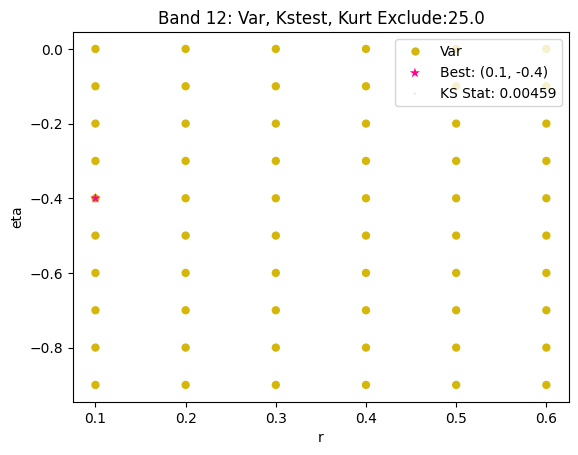

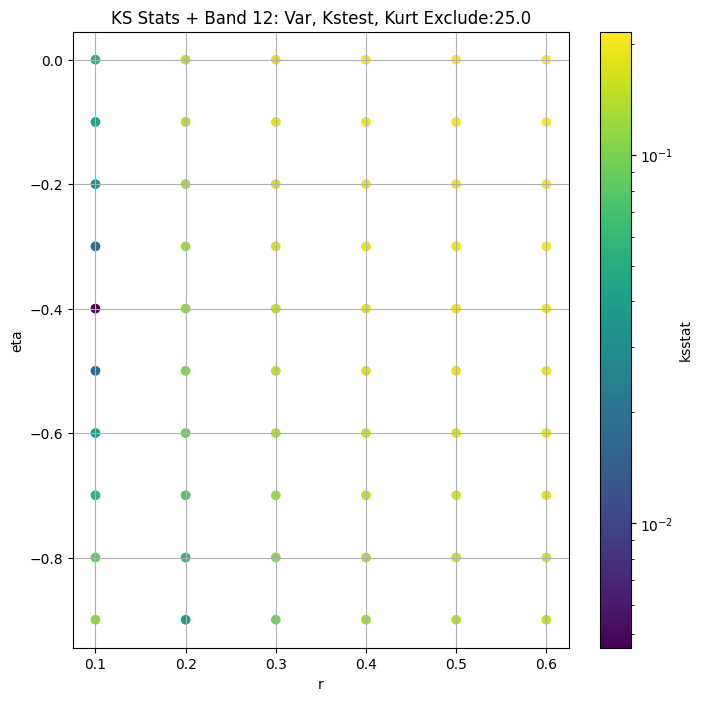

####
Band  14


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 0 0.014677182345925355 0.0003425828701842309


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 25 0.013475324998221239 0.00028984799158635256


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 50 0.011145587963951042 0.000265466534215385


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 75 0.013710284831307984 0.00024724729673370876


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 100 0.011261970406824529 0.00023248464698165803


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 150 0.008604304142145691 0.00020909196292323793


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 200 0.009379711684561642 0.00019086943596138844


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 250 0.007662779681377997 0.00017598214618778186


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 300 0.008849041699464391 0.00016346157941356362


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 350 0.009195513928109474 0.000152689508229846


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 500 0.011621428578070223 0.00012754798096776927
Number of samples: 100000, Without approximation : 12486961.0


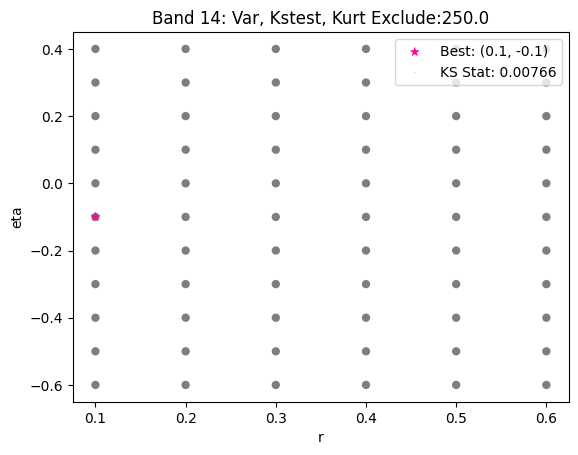

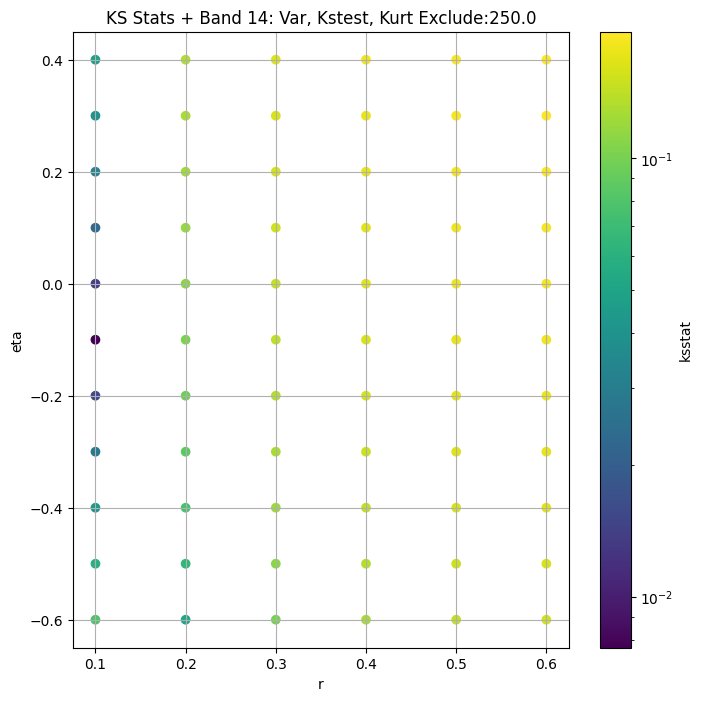

####
Band  16


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 0 0.030383871754255887 8.896086418327651e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 25 0.027186336114038534 6.379545957369444e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 50 0.027829519773479805 5.38279161659629e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 75 0.02543055412481232 4.702215755294225e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 100 0.019959064990994257 4.190254549000547e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 150 0.021549837425919982 3.447952514359238e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 200 0.018084886478706208 2.9238321458851414e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 250 0.01601508681795527 2.5316981598490495e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 300 0.015183546907589218 2.2266785783636428e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 350 0.012474404571479192 1.9823207850949512e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 500 0.009071079856177888 1.4751364849330787e-05
Number of samples: 100000, Without approximation : 8165465.0


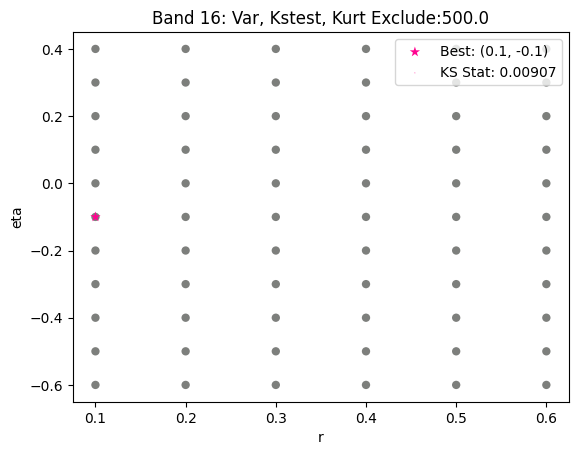

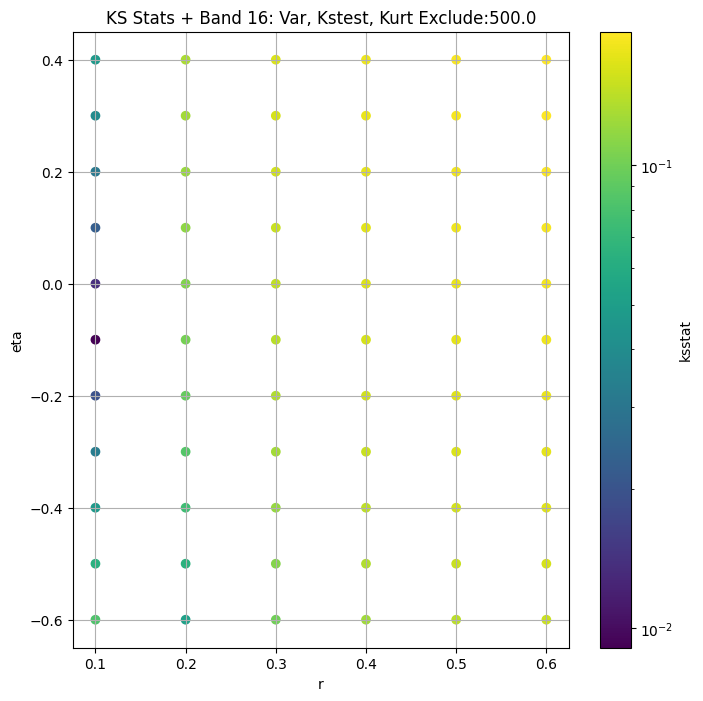

obs_var  var_lower  var_upper    obs_kurt  kurt_lower  kurt_upper  \
band                                                                       
2     0.029489   0.023873   0.036184   62.912878   39.554258   92.925360   
3     0.456956   0.403068   0.515163   20.634428   17.347091   24.231608   
5     2.054075   1.901039   2.211808    6.690379    5.783197    7.695582   
6     1.437103   1.323974   1.553742    7.705143    6.794343    8.683341   
8     0.119230   0.105100   0.135650   22.735538   14.230040   38.649732   
9     0.038668   0.034168   0.044289   22.991529   12.297513   58.716762   
11    0.017660   0.014538   0.021348   52.619247   33.954769   94.025944   
12    0.005025   0.003985   0.006606   93.957778   41.206982  280.084258   
14    0.000343   0.000266   0.000455  107.904099   46.007350  303.776315   
16    0.000089   0.000058   0.000144  337.955866  110.806686  914.250102   

      total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                               
2           98098.0             0.003145        0.3         -0.6   
3          109212.0             0.015147        0.2         -1.0   
5         1081864.0             0.007433        0.7         -1.1   
6          546468.0             0.009214        0.7         -1.2   
8         3541926.0             0.003420        0.5         -1.1   
9         5314425.0             0.002833        0.5         -1.1   
11        6734585.0             0.006856        0.1         -0.4   
12       22178309.0             0.004590        0.1         -0.4   
14       12486961.0             0.007663        0.1         -0.1   
16        8165465.0             0.009071        0.1         -0.1   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      1.633606e-04                   200.0            0.017481   
3      3.246221e-04                     0.0            0.456956   
5      3.033826e+00                    75.0            1.946531   
6      2.922976e+00                   100.0            1.339967   
8      8.279893e-02                     0.0            0.119230   
9      2.506616e-02                    25.0            0.036095   
11     2.365839e-14                    25.0            0.015862   
12     6.462369e-15                    25.0            0.004333   
14     4.238913e-17                   250.0            0.000176   
16     3.553187e-18                   500.0            0.000015   

      kstest_stat_cutoff_0.05  
band                           
2                    0.004334  
3                    0.004108  
5                    0.001306  
6                    0.001837  
8                    0.000722  
9                    0.000589  
11                   0.000523  
12                   0.000288  
14                   0.000384  
16                   0.000475

In [16]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [17]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Band 2


  0%|          | 0/1332 [00:00<?, ?it/s]

Finding Minimum after computing 1332 CDFs
band 2, 200.0 + 100 = 300, ksstat: 0.004189449086457177, var: 0.01546814931924455


  0%|          | 0/1332 [00:00<?, ?it/s]

Finding Minimum after computing 1332 CDFs
band 2, 200.0 + 75 = 275, ksstat: 0.003878277167817584, var: 0.015892345574746468


  0%|          | 0/1332 [00:00<?, ?it/s]

Finding Minimum after computing 1332 CDFs
band 2, 200.0 + 50 = 250, ksstat: 0.0036029848605848855, var: 0.01636370325609879


  0%|          | 0/1332 [00:00<?, ?it/s]

Finding Minimum after computing 1332 CDFs
band 2, 200.0 + 25 = 225, ksstat: 0.003315062484216145, var: 0.01689164190969452


  0%|          | 0/1332 [00:00<?, ?it/s]

Finding Minimum after computing 1332 CDFs
band 2, 200.0 + 0 = 200, ksstat: 0.0029994782391387833, var: 0.01748131208581403


  0%|          | 0/1332 [00:00<?, ?it/s]

Finding Minimum after computing 1332 CDFs
band 2, 200.0 + -25 = 175, ksstat: 0.0027423036236027738, var: 0.01815186424801946


  0%|          | 0/1332 [00:00<?, ?it/s]

Finding Minimum after computing 1332 CDFs
band 2, 200.0 + -50 = 150, ksstat: 0.0025079507363431897, var: 0.018913163765309774


  0%|          | 0/1332 [00:00<?, ?it/s]

Finding Minimum after computing 1332 CDFs
band 2, 200.0 + -75 = 125, ksstat: 0.00276143712749366, var: 0.01977628455987786


  0%|          | 0/1332 [00:00<?, ?it/s]

Finding Minimum after computing 1332 CDFs
band 2, 200.0 + -100 = 100, ksstat: 0.003825021906840531, var: 0.02077743663867458
Number of samples: 100000, Without approximation : 98098.0


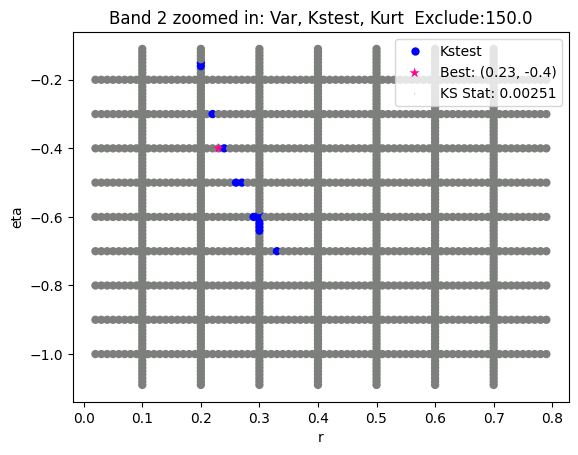

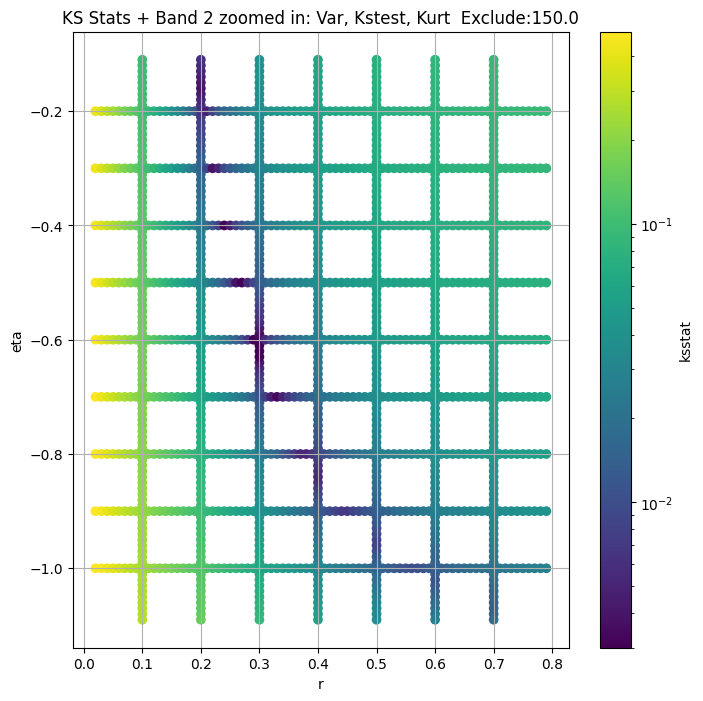

Band 3


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 3, 0.0 + 100 = 100, ksstat: 0.015293588092301635, var: 0.395546000550584


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 3, 0.0 + 75 = 75, ksstat: 0.014835903410211147, var: 0.40764048686220367


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 3, 0.0 + 50 = 50, ksstat: 0.013904734339355143, var: 0.4213004072908535


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 3, 0.0 + 25 = 25, ksstat: 0.014758299380929096, var: 0.4367982935231229


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 3, 0.0 + 0 = 0, ksstat: 0.014592182505821241, var: 0.45695630881276766
Number of samples: 100000, Without approximation : 109212.0


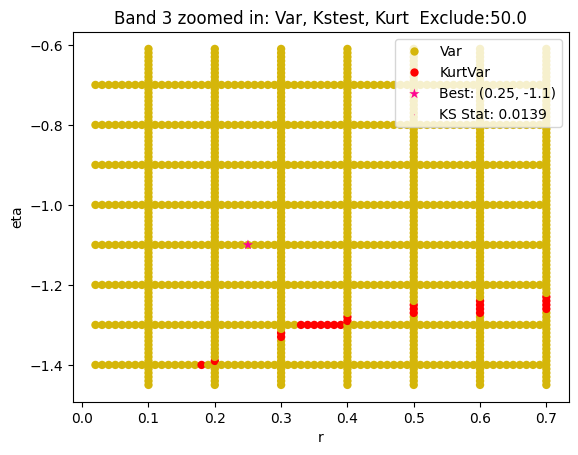

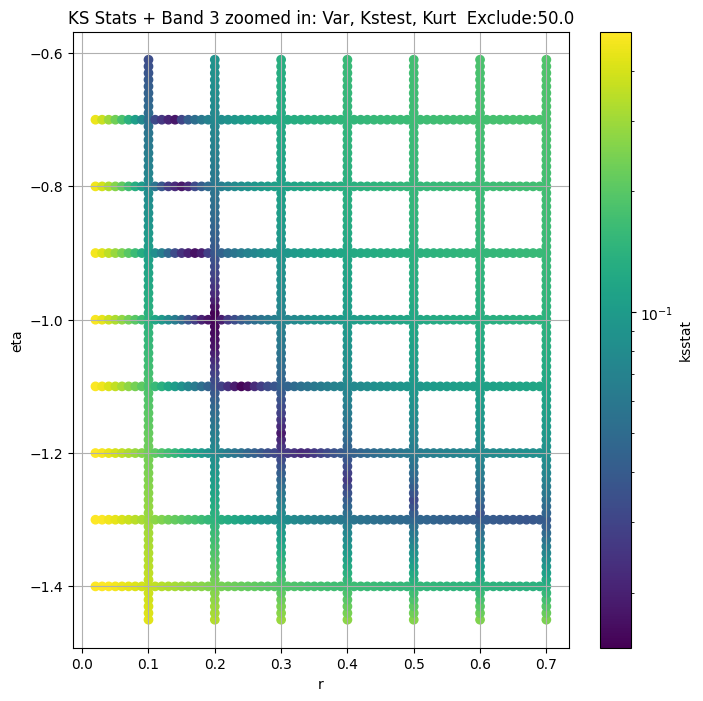

Band 5


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
band 5, 75.0 + 100 = 175, ksstat: 0.005944342634371748, var: 1.844261643202382


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
band 5, 75.0 + 75 = 150, ksstat: 0.005429069490311744, var: 1.8675817852407253


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
band 5, 75.0 + 50 = 125, ksstat: 0.005524126061411304, var: 1.8921849625789382


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
band 5, 75.0 + 25 = 100, ksstat: 0.005876530410418232, var: 1.9183948586041608


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
band 5, 75.0 + 0 = 75, ksstat: 0.005381058546745865, var: 1.946530865178164


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
band 5, 75.0 + -25 = 50, ksstat: 0.0049442419488267, var: 1.9769853714919237


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
band 5, 75.0 + -50 = 25, ksstat: 0.004699087961173631, var: 2.011026561682566


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
band 5, 75.0 + -75 = 0, ksstat: 0.004520939521587969, var: 2.0540750755858106
Number of samples: 100000, Without approximation : 1081864.0


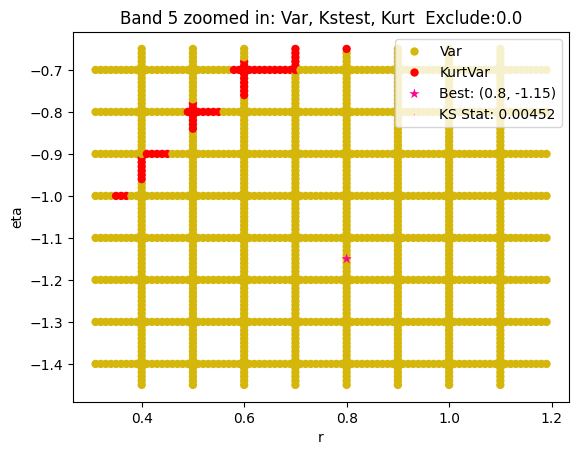

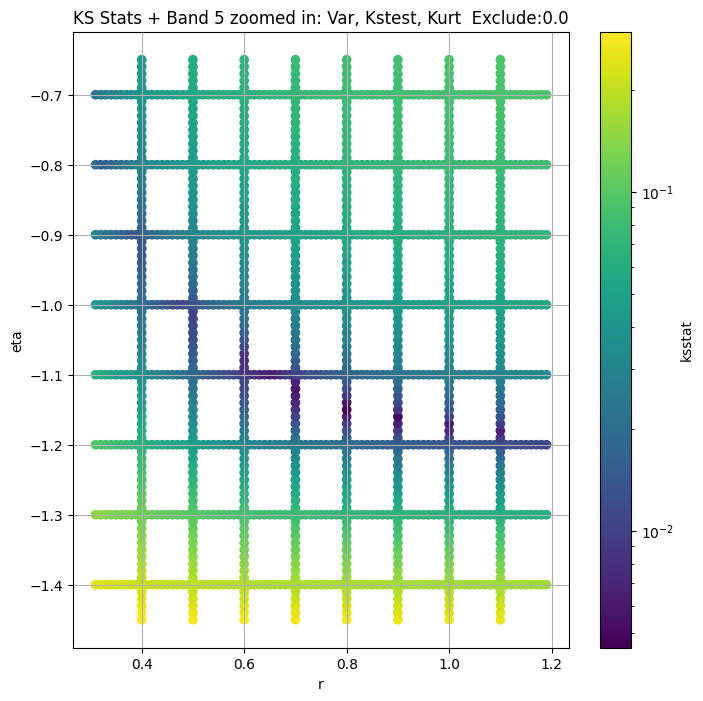

Band 6


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
band 6, 100.0 + 100 = 200, ksstat: 0.010276833736819091, var: 1.2697384003232244


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
band 6, 100.0 + 75 = 175, ksstat: 0.010002569497974761, var: 1.2859860693939464


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
band 6, 100.0 + 50 = 150, ksstat: 0.009712935751292666, var: 1.3029909572749288


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
band 6, 100.0 + 25 = 125, ksstat: 0.009410738562575627, var: 1.320959242942502


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
band 6, 100.0 + 0 = 100, ksstat: 0.009214138921397885, var: 1.3399669214809344


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
band 6, 100.0 + -25 = 75, ksstat: 0.008976913828756018, var: 1.3603888775505502


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
band 6, 100.0 + -50 = 50, ksstat: 0.008619680065980267, var: 1.3825887301017554


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
band 6, 100.0 + -75 = 25, ksstat: 0.00855251014324443, var: 1.4072519565930828


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
band 6, 100.0 + -100 = 0, ksstat: 0.008628018584232677, var: 1.4371025797221268
Number of samples: 100000, Without approximation : 546468.0


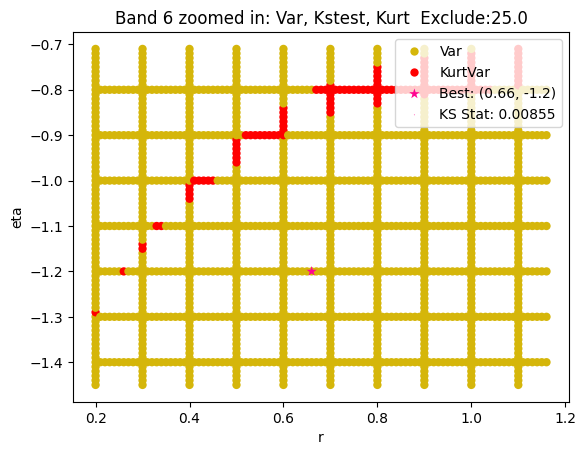

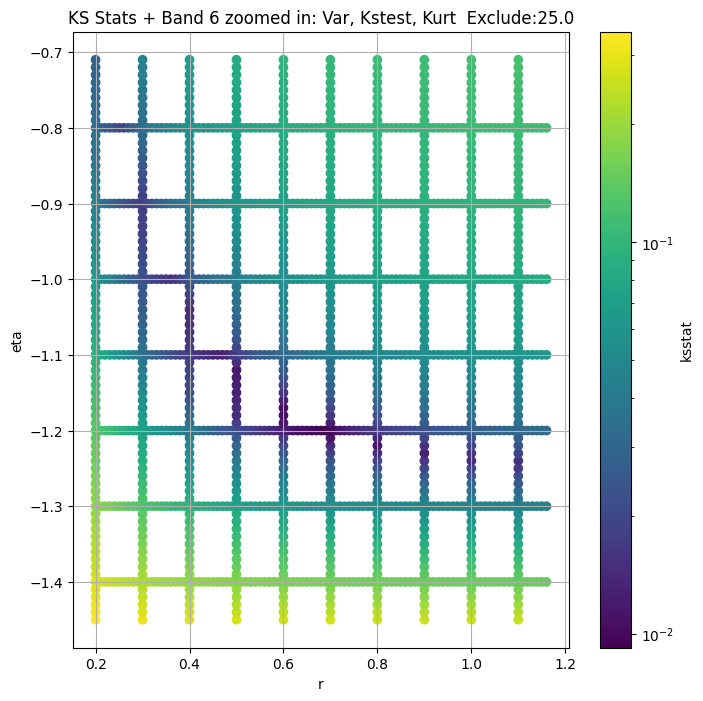

Band 8


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
band 8, 0.0 + 100 = 100, ksstat: 0.00260275704737338, var: 0.10031080430851871


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
band 8, 0.0 + 75 = 75, ksstat: 0.002327297660027594, var: 0.10329052194247605


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
band 8, 0.0 + 50 = 50, ksstat: 0.002019999427119723, var: 0.106835268566401


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
band 8, 0.0 + 25 = 25, ksstat: 0.0020497234658024, var: 0.11133899084102164


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
band 8, 0.0 + 0 = 0, ksstat: 0.002609275087062532, var: 0.11923045292271141
Number of samples: 100000, Without approximation : 3541926.0


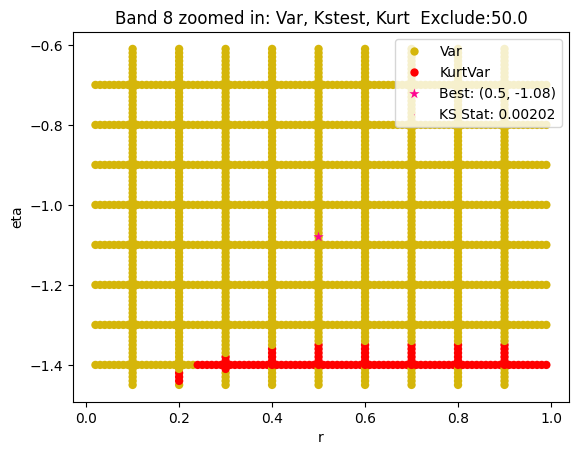

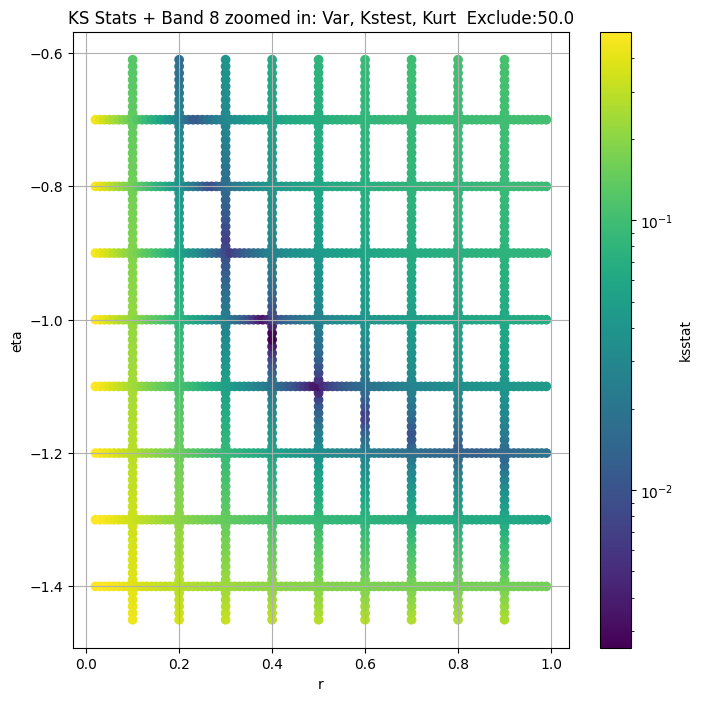

Band 9


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
band 9, 25.0 + 100 = 125, ksstat: 0.004092490581601389, var: 0.03210683432606746


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
band 9, 25.0 + 75 = 100, ksstat: 0.003252636304521765, var: 0.03285994559082227


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
band 9, 25.0 + 50 = 75, ksstat: 0.0033511467576367027, var: 0.03372472991280935


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
band 9, 25.0 + 25 = 50, ksstat: 0.0030027853145525585, var: 0.034758767239025545


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
band 9, 25.0 + 0 = 25, ksstat: 0.002071105158310979, var: 0.03609527512608224


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
band 9, 25.0 + -25 = 0, ksstat: 0.0018830313368827234, var: 0.03866770635377723
Number of samples: 100000, Without approximation : 5314425.0


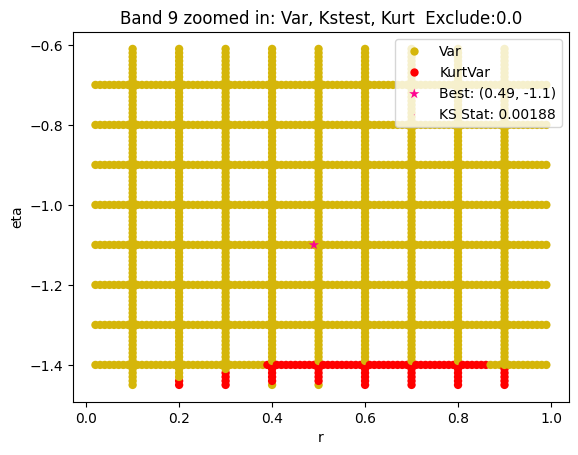

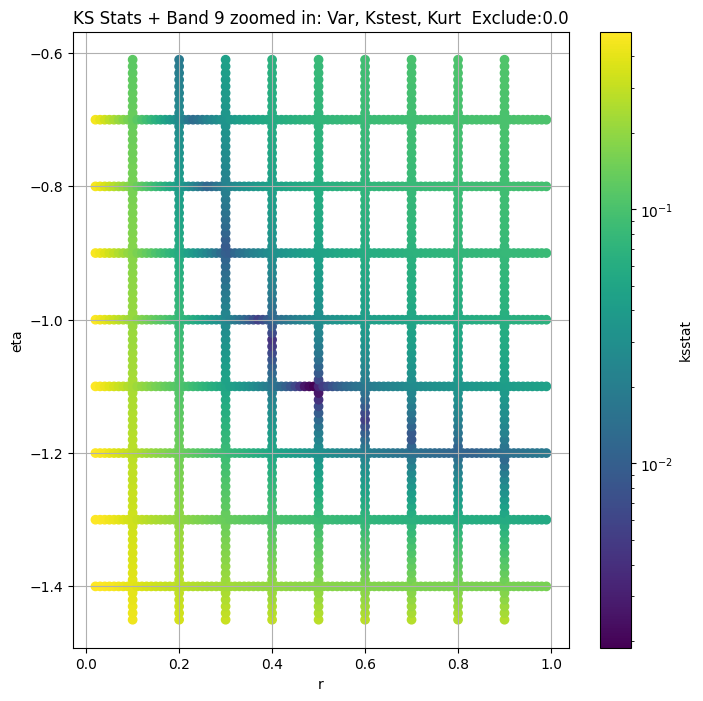

Band 11


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 11, 25.0 + 100 = 125, ksstat: 0.00631744833093752, var: 0.01275193076124113


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 11, 25.0 + 75 = 100, ksstat: 0.0066341421087324215, var: 0.01333994763835071


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 11, 25.0 + 50 = 75, ksstat: 0.00683738803788031, var: 0.014018005497719107


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 11, 25.0 + 25 = 50, ksstat: 0.005762577479494435, var: 0.014827529534539483


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 11, 25.0 + 0 = 25, ksstat: 0.005309766638040815, var: 0.015861594498927788


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 11, 25.0 + -25 = 0, ksstat: 0.004929629122632756, var: 0.017660436665729196
Number of samples: 100000, Without approximation : 6734585.0


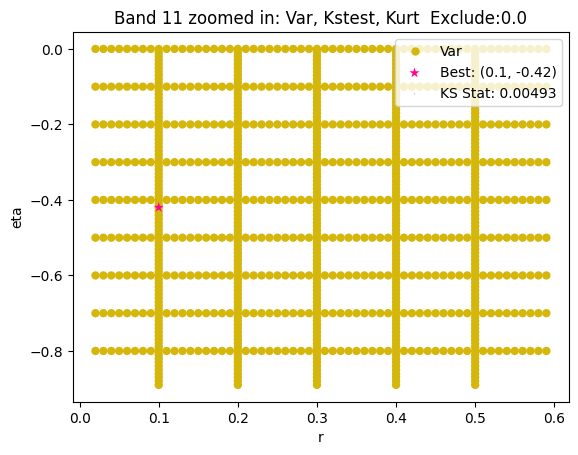

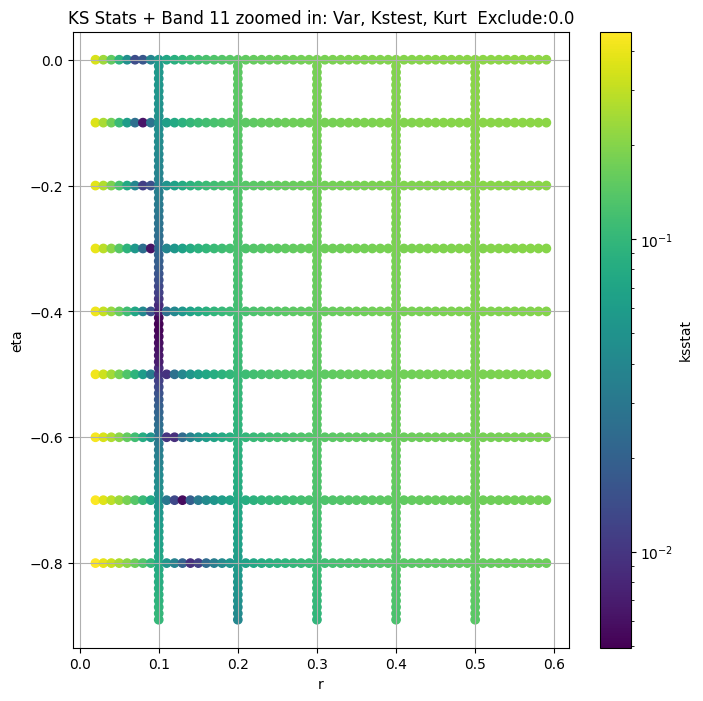

Band 12


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 12, 25.0 + 100 = 125, ksstat: 0.006026790826233849, var: 0.003362876624002931


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 12, 25.0 + 75 = 100, ksstat: 0.006499890813645107, var: 0.003539880631860417


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 12, 25.0 + 50 = 75, ksstat: 0.005858437166972628, var: 0.0037474000622586654


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 12, 25.0 + 25 = 50, ksstat: 0.005120397230871248, var: 0.004000089529944735


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 12, 25.0 + 0 = 25, ksstat: 0.00458952348956454, var: 0.00433264737180503


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 12, 25.0 + -25 = 0, ksstat: 0.006219188792262131, var: 0.005025361482475439
Number of samples: 100000, Without approximation : 22178309.0


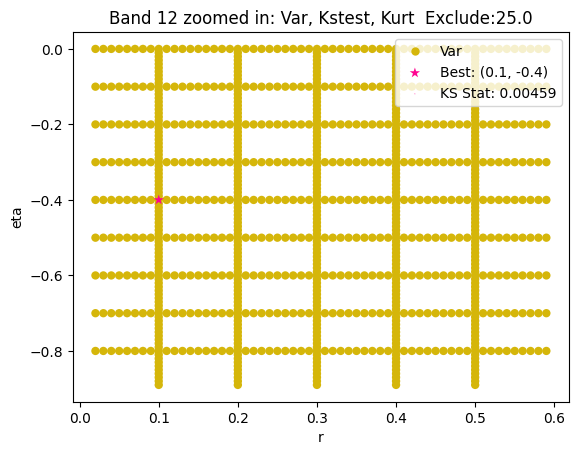

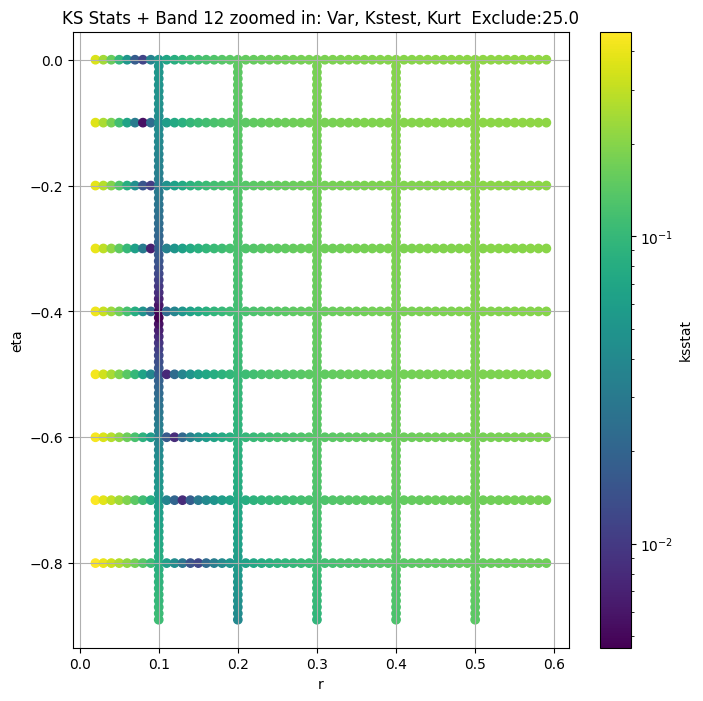

Band 14


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 14, 250.0 + 100 = 350, ksstat: 0.008420724446579625, var: 0.000152689508229846


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 14, 250.0 + 75 = 325, ksstat: 0.007931970246424589, var: 0.00015788355293213


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 14, 250.0 + 50 = 300, ksstat: 0.008197748653832049, var: 0.00016346157941356362


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 14, 250.0 + 25 = 275, ksstat: 0.007657917914597759, var: 0.00016947758849291593


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 14, 250.0 + 0 = 250, ksstat: 0.00746372755438297, var: 0.00017598214618778186


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 14, 250.0 + -25 = 225, ksstat: 0.007090165890478627, var: 0.00018307944811388243


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 14, 250.0 + -50 = 200, ksstat: 0.006703350459624981, var: 0.00019086943596138844


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 14, 250.0 + -75 = 175, ksstat: 0.006415993130278852, var: 0.0001994806742336999


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 14, 250.0 + -100 = 150, ksstat: 0.006319331214772347, var: 0.00020909196292323793
Number of samples: 100000, Without approximation : 12486961.0


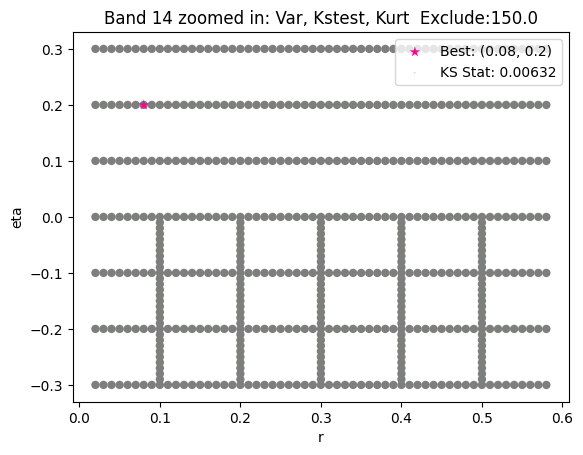

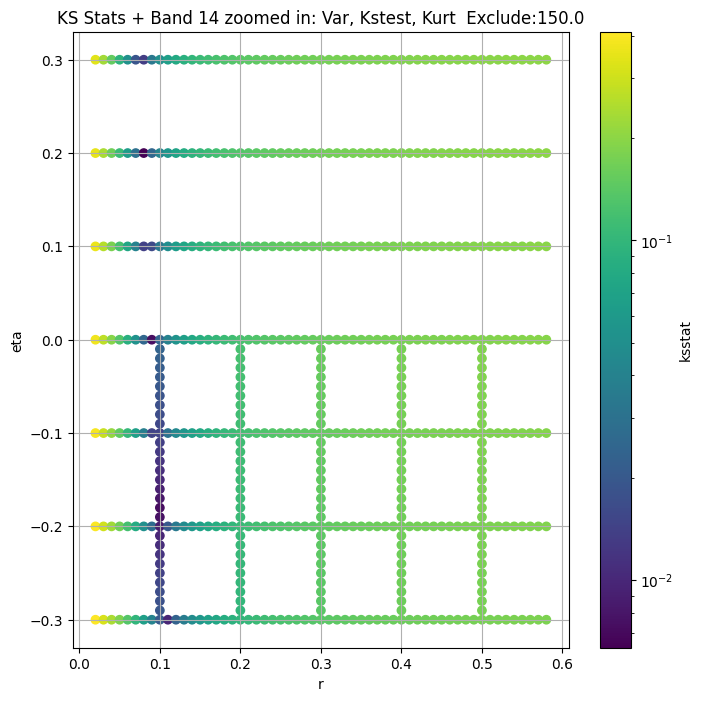

Band 16


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 16, 500.0 + 100 = 600, ksstat: 0.009381912399193195, var: 1.2517069601515392e-05


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 16, 500.0 + 75 = 575, ksstat: 0.008918103239977536, var: 1.3015993118904077e-05


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 16, 500.0 + 50 = 550, ksstat: 0.008661377414557263, var: 1.3551404817474997e-05


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 16, 500.0 + 25 = 525, ksstat: 0.00844680379680179, var: 1.4128345036246703e-05


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 16, 500.0 + 0 = 500, ksstat: 0.008219278378744069, var: 1.4751364849330787e-05


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 16, 500.0 + -25 = 475, ksstat: 0.007885289124325387, var: 1.5425916319250226e-05


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 16, 500.0 + -50 = 450, ksstat: 0.008284450866532178, var: 1.6159049694971773e-05


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 16, 500.0 + -75 = 425, ksstat: 0.008831270412027081, var: 1.695635848243961e-05


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 16, 500.0 + -100 = 400, ksstat: 0.00842568855234993, var: 1.7825429849654826e-05
Number of samples: 100000, Without approximation : 8165465.0


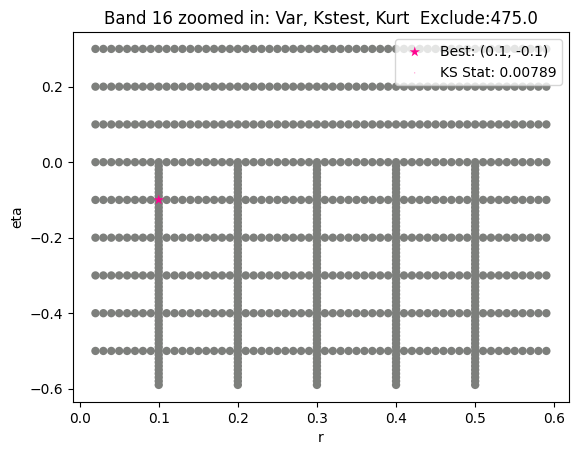

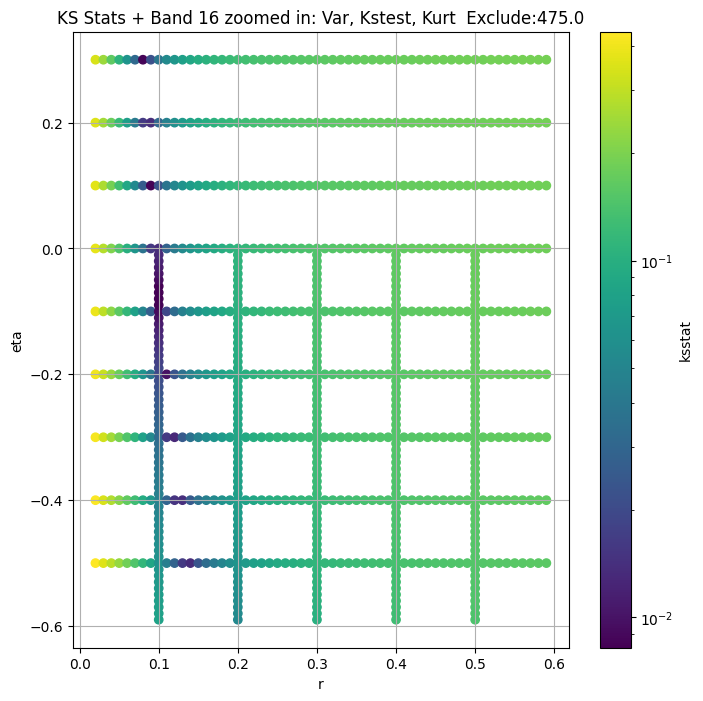

obs_var  var_lower  var_upper    obs_kurt  kurt_lower  kurt_upper  \
band                                                                       
2     0.029489   0.023873   0.036184   62.912878   39.554258   92.925360   
3     0.456956   0.403068   0.515163   20.634428   17.347091   24.231608   
5     2.054075   1.901039   2.211808    6.690379    5.783197    7.695582   
6     1.437103   1.323974   1.553742    7.705143    6.794343    8.683341   
8     0.119230   0.105100   0.135650   22.735538   14.230040   38.649732   
9     0.038668   0.034168   0.044289   22.991529   12.297513   58.716762   
11    0.017660   0.014538   0.021348   52.619247   33.954769   94.025944   
12    0.005025   0.003985   0.006606   93.957778   41.206982  280.084258   
14    0.000343   0.000266   0.000455  107.904099   46.007350  303.776315   
16    0.000089   0.000058   0.000144  337.955866  110.806686  914.250102   

      total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                               
2           98098.0             0.003145        0.3         -0.6   
3          109212.0             0.015147        0.2         -1.0   
5         1081864.0             0.007433        0.7         -1.1   
6          546468.0             0.009214        0.7         -1.2   
8         3541926.0             0.003420        0.5         -1.1   
9         5314425.0             0.002833        0.5         -1.1   
11        6734585.0             0.006856        0.1         -0.4   
12       22178309.0             0.004590        0.1         -0.4   
14       12486961.0             0.007663        0.1         -0.1   
16        8165465.0             0.009071        0.1         -0.1   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      1.633606e-04                   200.0            0.018913   
3      3.246221e-04                     0.0            0.421300   
5      3.033826e+00                    75.0            2.054075   
6      2.922976e+00                   100.0            1.407252   
8      8.279893e-02                     0.0            0.106835   
9      2.506616e-02                    25.0            0.038668   
11     2.365839e-14                    25.0            0.017660   
12     6.462369e-15                    25.0            0.004333   
14     4.238913e-17                   250.0            0.000209   
16     3.553187e-18                   500.0            0.000015   

      kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
band                                                                
2                    0.004334          0.002508    0.23     -0.40   
3                    0.004108          0.013905    0.25     -1.10   
5                    0.001306          0.004521    0.80     -1.15   
6                    0.001837          0.008553    0.66     -1.20   
8                    0.000722          0.002020    0.50     -1.08   
9                    0.000589          0.001883    0.49     -1.10   
11                   0.000523          0.004930    0.10     -0.42   
12                   0.000288          0.004590    0.10     -0.40   
14                   0.000384          0.006319    0.08      0.20   
16                   0.000475          0.007885    0.10     -0.10   

        best_scale  best_exclude_cutoff  n_pval_0.05  
band                                                  
2     6.164174e-06                150.0       279348  
3     6.115588e-03                 50.0         9714  
5     4.588964e+00                  0.0        91381  
6     2.776380e+00                 25.0        25615  
8     6.912220e-02                 50.0       442740  
9     2.518339e-02                  0.0       498226  
11    3.013946e-14                  0.0        78919  
12    6.462369e-15                 25.0        86634  
14    3.000847e-22                150.0        48777  
16    3.715668e-18                475.

In [18]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

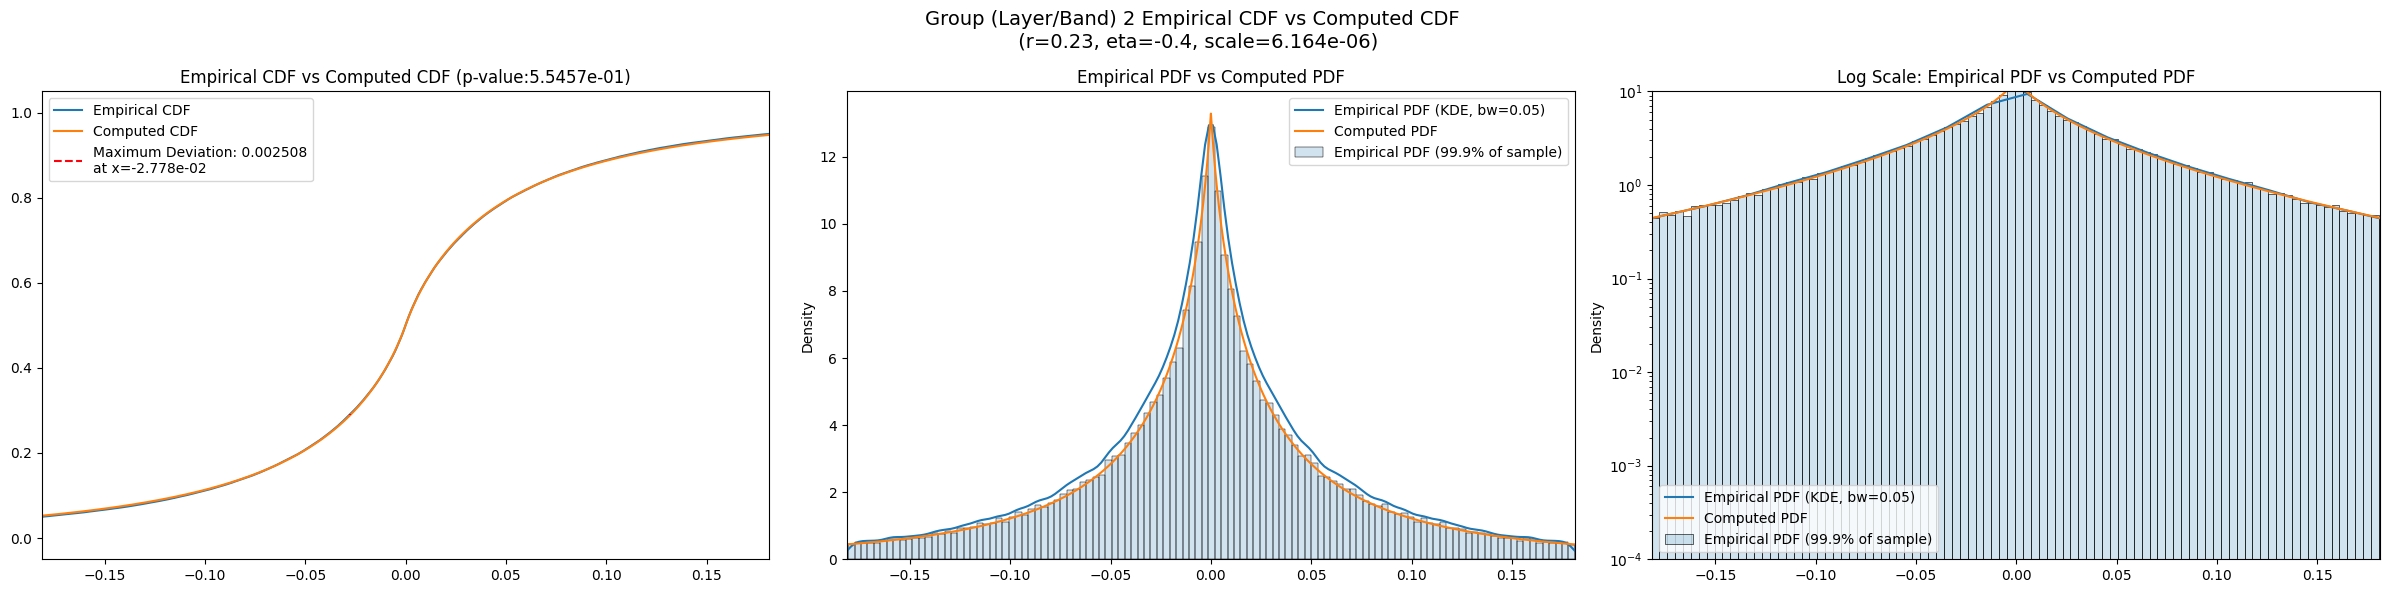

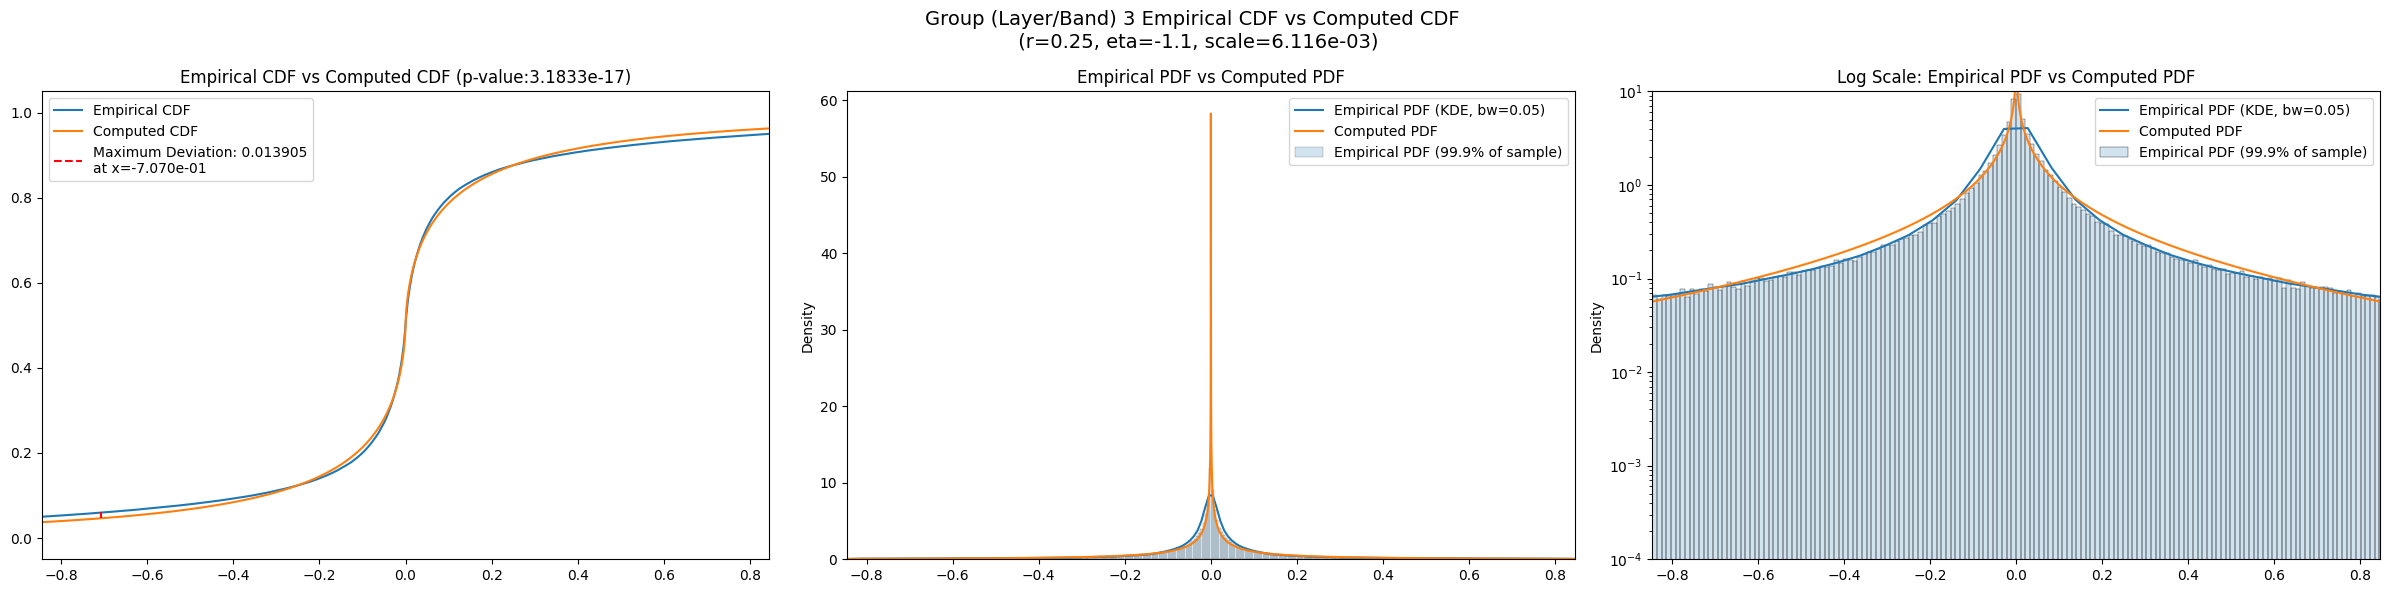

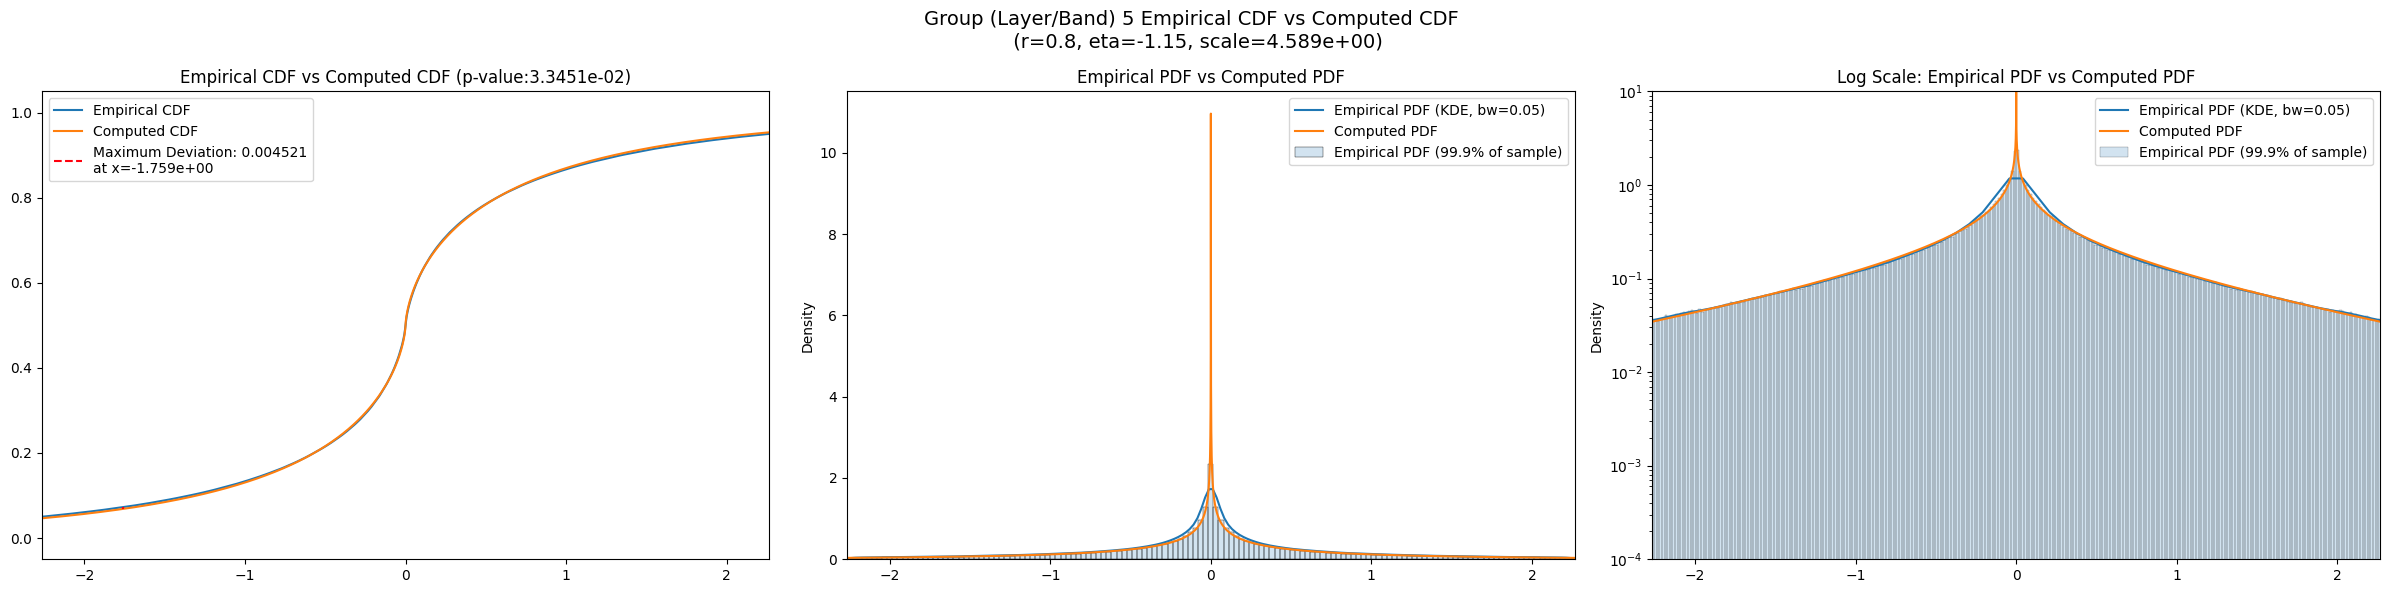

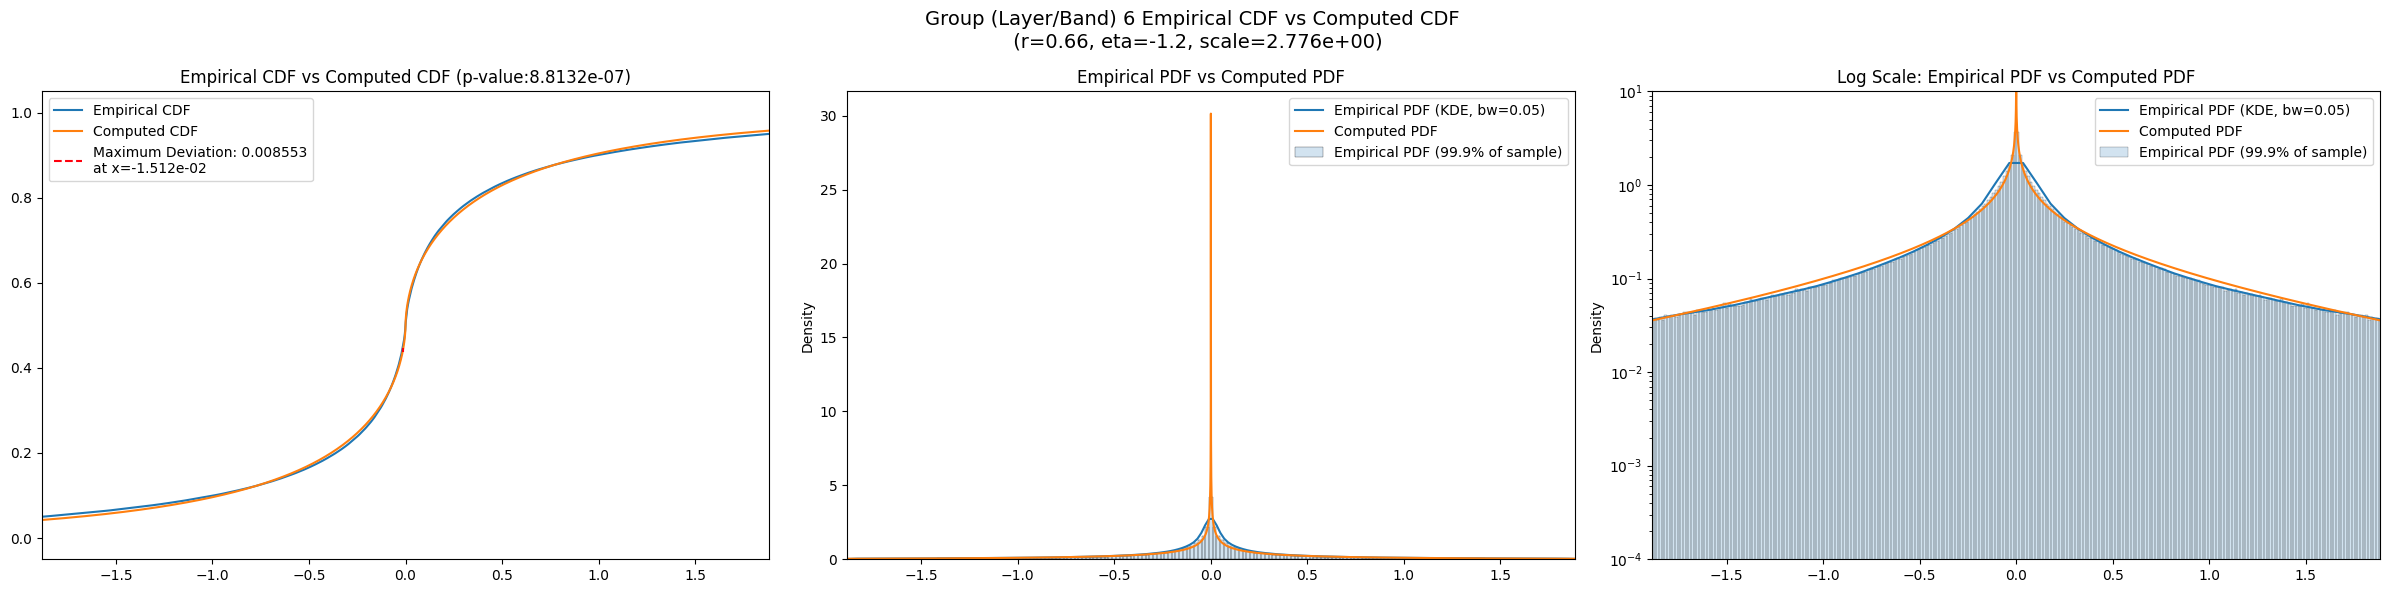

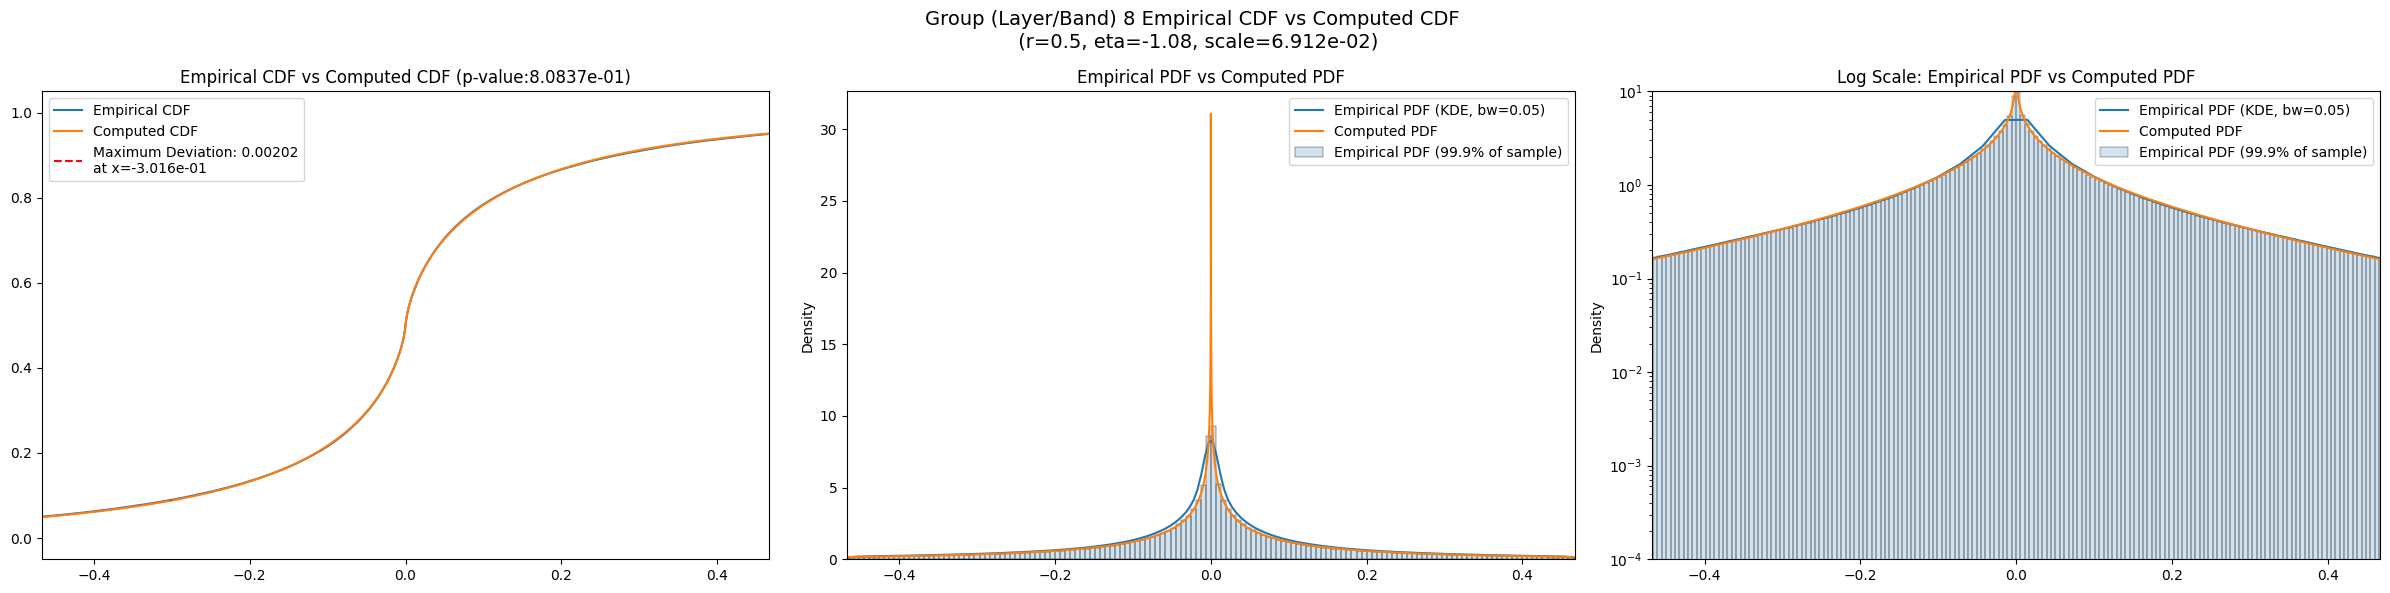

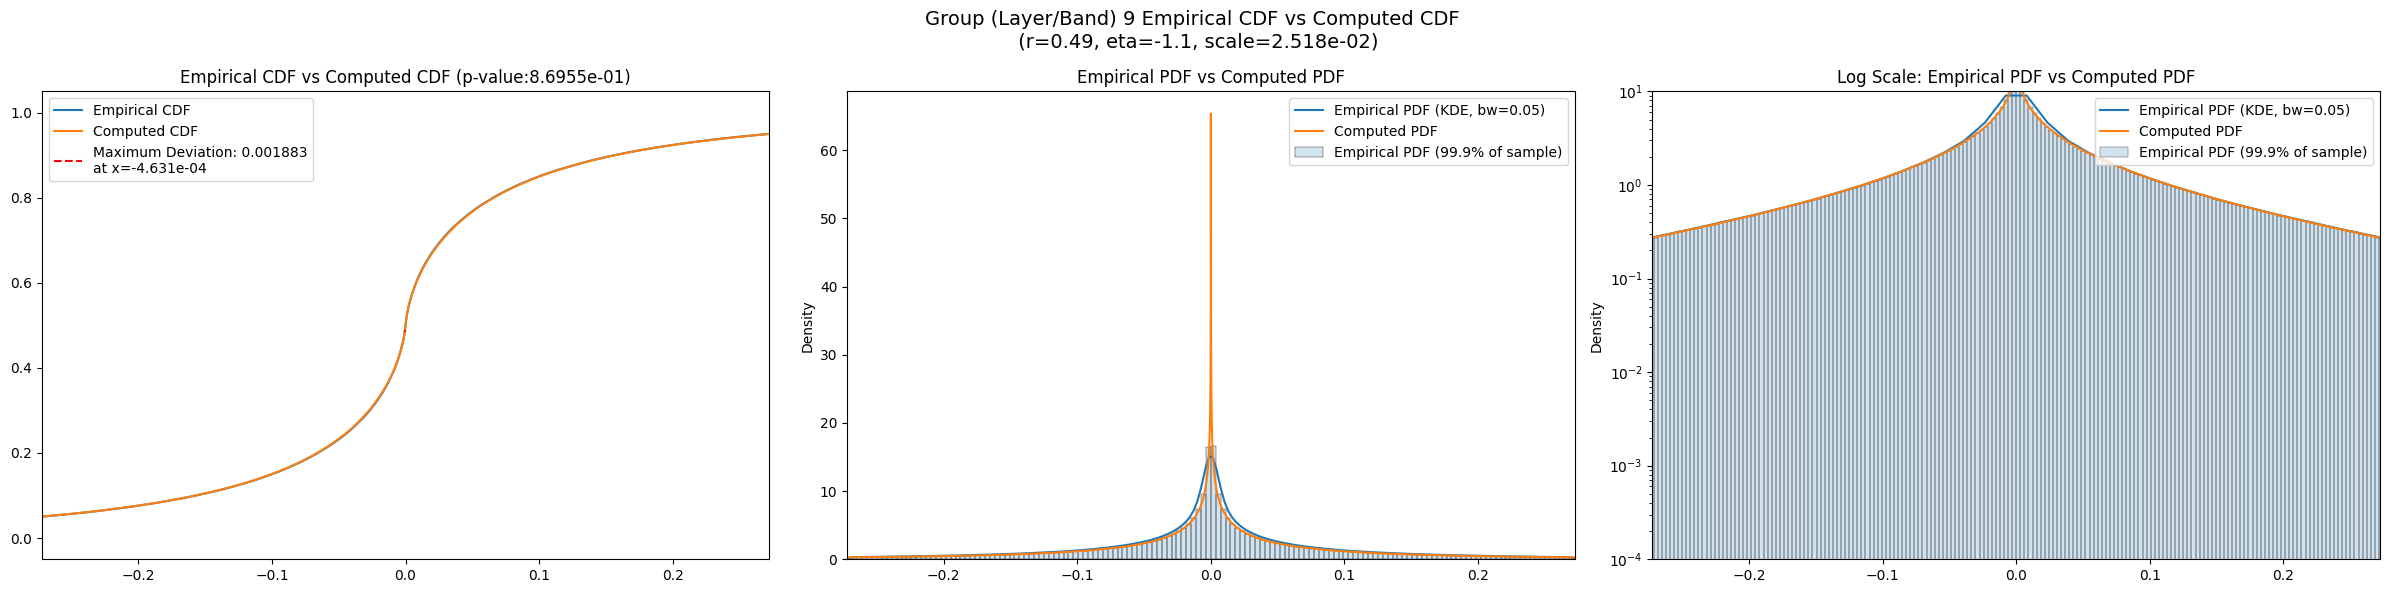

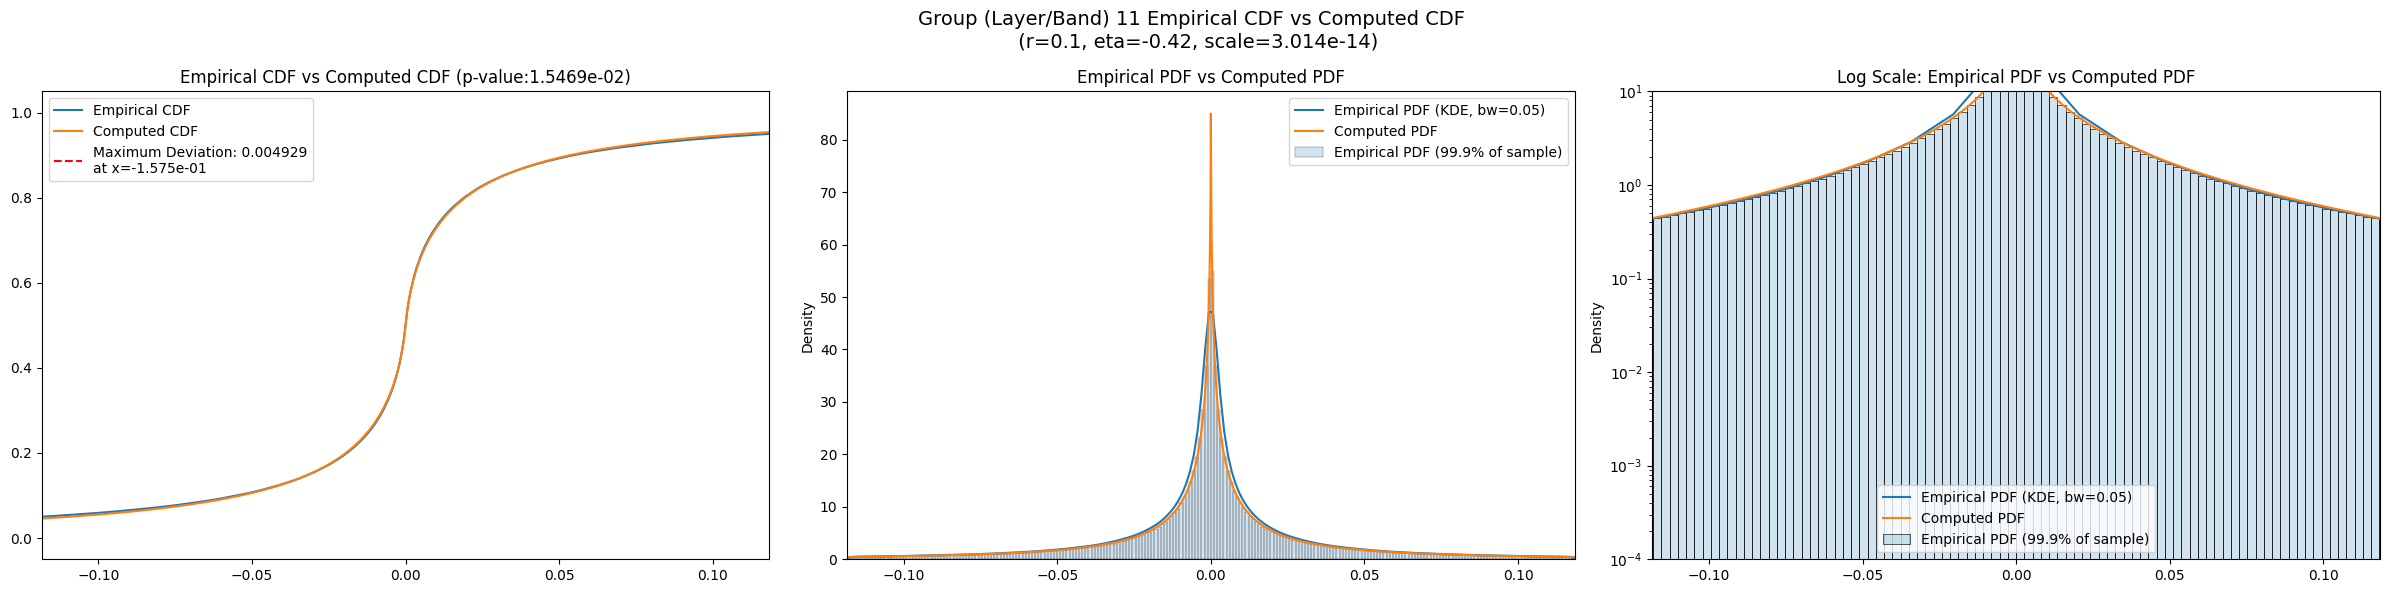

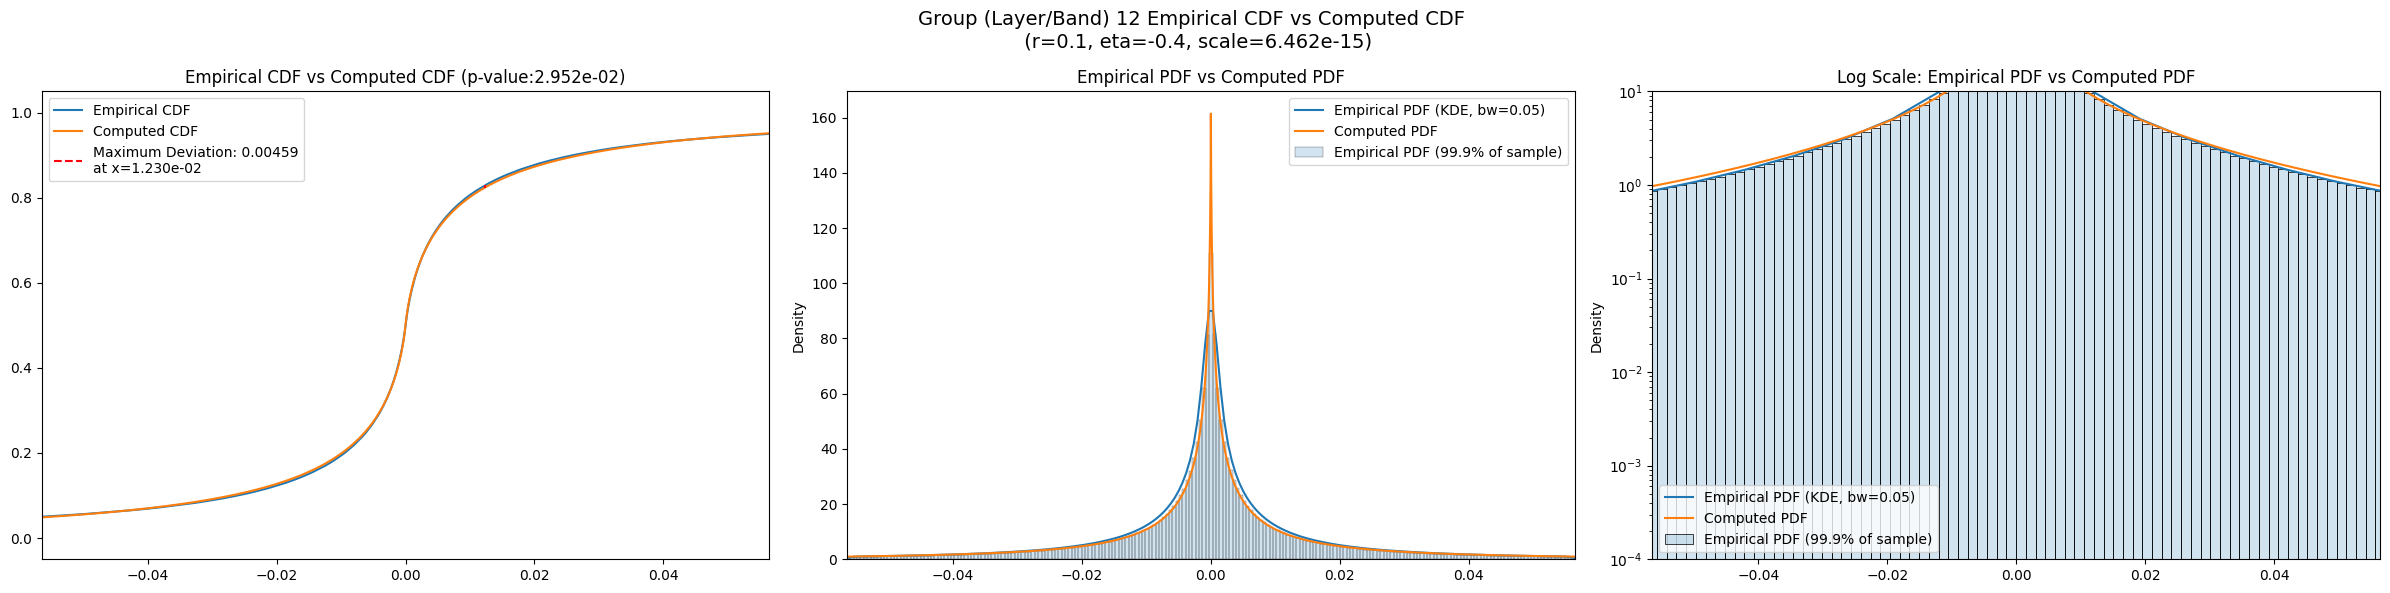

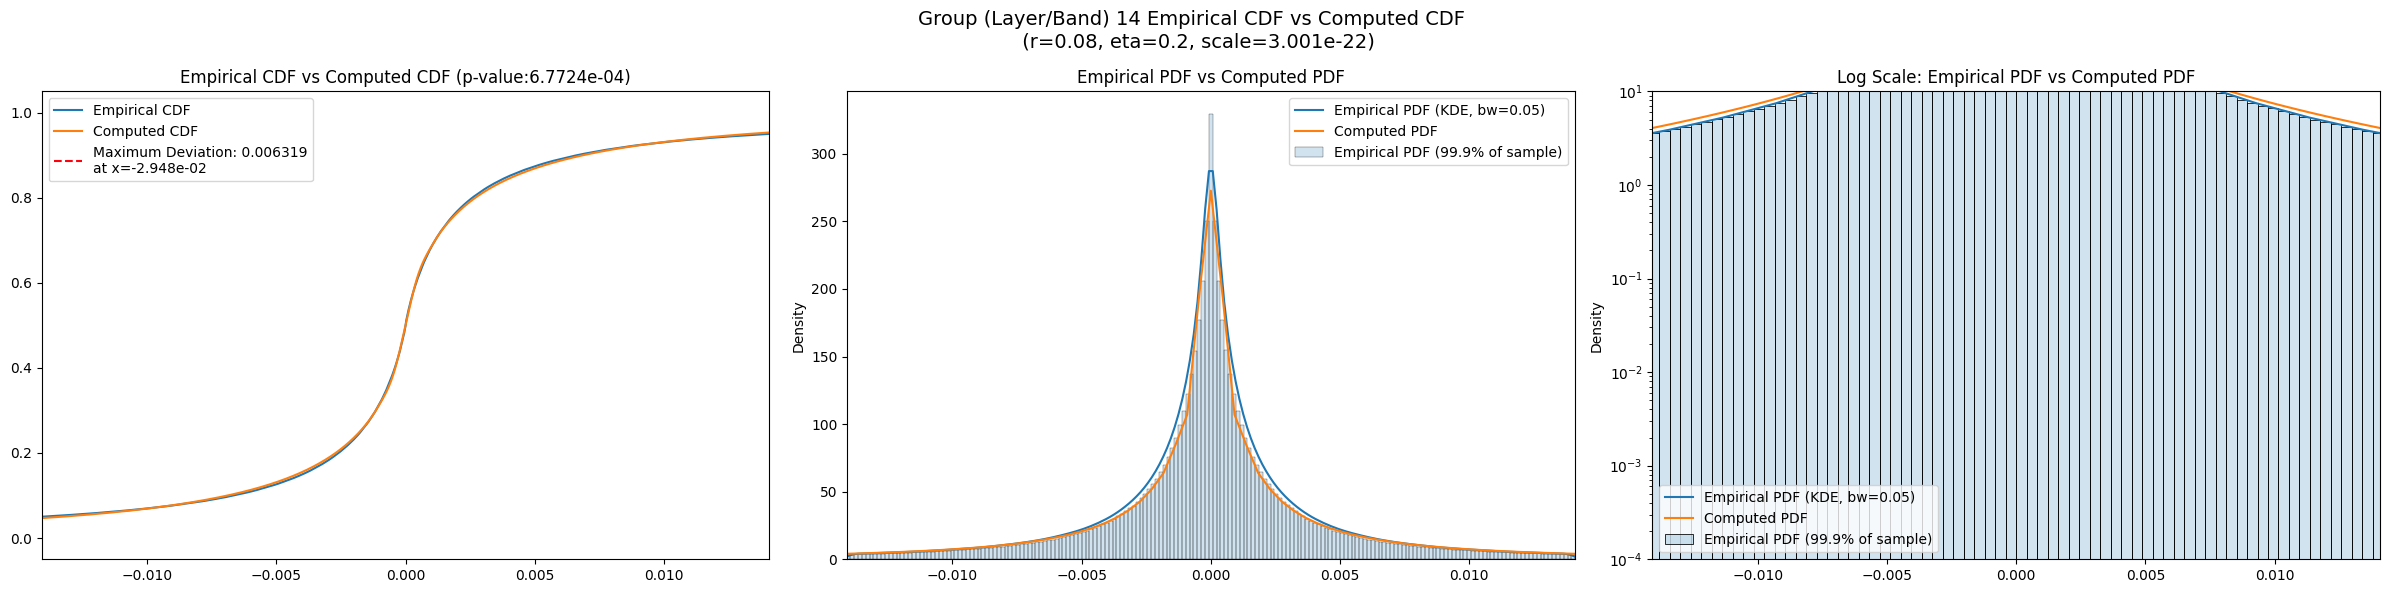

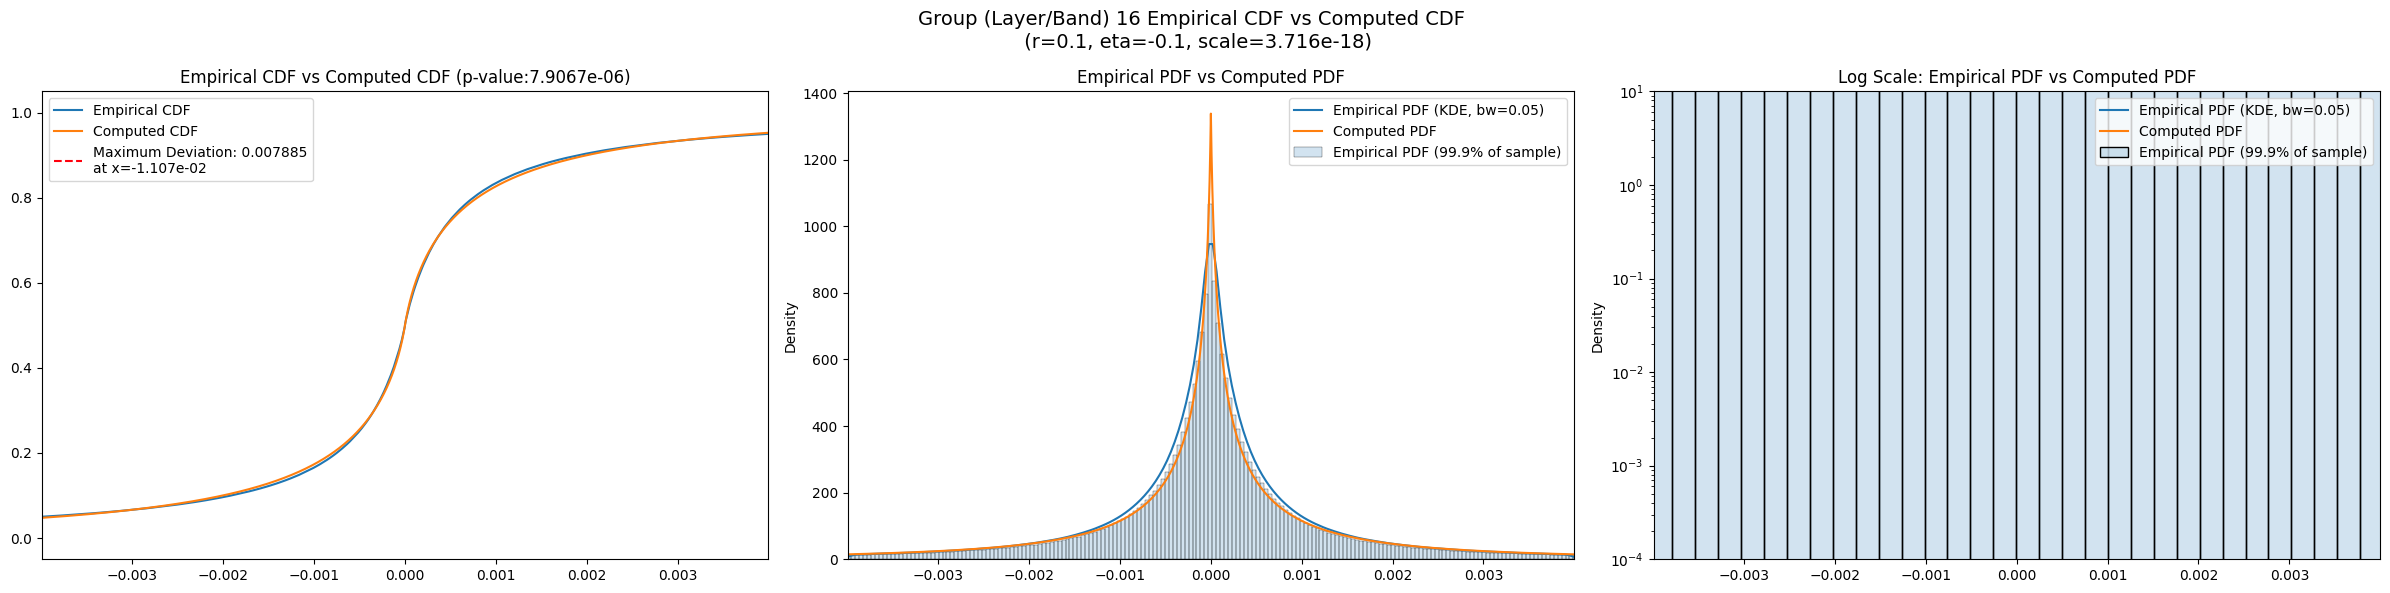

In [19]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [20]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [21]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var  var_lower  var_upper    obs_kurt  kurt_lower  kurt_upper  \
band                                                                       
2     0.029489   0.023873   0.036184   62.912878   39.554258   92.925360   
3     0.456956   0.403068   0.515163   20.634428   17.347091   24.231608   
5     2.054075   1.901039   2.211808    6.690379    5.783197    7.695582   
6     1.437103   1.323974   1.553742    7.705143    6.794343    8.683341   
8     0.119230   0.105100   0.135650   22.735538   14.230040   38.649732   
9     0.038668   0.034168   0.044289   22.991529   12.297513   58.716762   
11    0.017660   0.014538   0.021348   52.619247   33.954769   94.025944   
12    0.005025   0.003985   0.006606   93.957778   41.206982  280.084258   
14    0.000343   0.000266   0.000455  107.904099   46.007350  303.776315   
16    0.000089   0.000058   0.000144  337.955866  110.806686  914.250102   

      total_samples  kstest_stat_initial  initial_r  initial_eta  ...  \
band                                                              ...   
2           98098.0             0.003145        0.3         -0.6  ...   
3          109212.0             0.015147        0.2         -1.0  ...   
5         1081864.0             0.007433        0.7         -1.1  ...   
6          546468.0             0.009214        0.7         -1.2  ...   
8         3541926.0             0.003420        0.5         -1.1  ...   
9         5314425.0             0.002833        0.5         -1.1  ...   
11        6734585.0             0.006856        0.1         -0.4  ...   
12       22178309.0             0.004590        0.1         -0.4  ...   
14       12486961.0             0.007663        0.1         -0.1  ...   
16        8165465.0             0.009071        0.1         -0.1  ...   

      param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
band                                                               
2           0.067891              0.053983         6.551250e-249   
3           0.141814              0.095393          0.000000e+00   
5           0.698058              0.073724          0.000000e+00   
6           0.462148              0.084686          0.000000e+00   
8           0.143869              0.071875          0.000000e+00   
9           0.081004              0.074312          0.000000e+00   
11          0.025023              0.086088          0.000000e+00   
12          0.012593              0.081572          0.000000e+00   
14          0.003553              0.073419          0.000000e+00   
16          0.001042              0.072013          0.000000e+00   

      param_laplace  kstest_stat_laplace  kstest_pval_laplace   param_t  \
band                                                                      
2          0.059207             0.027702         7.803930e-66  0.046726   
3          0.126722             0.072237         0.000000e+00  0.094739   
5          0.597161             0.048384         0.000000e+00  0.469674   
6          0.399727             0.059985         0.000000e+00  0.306170   
8          0.123619             0.046333         0.000000e+00  0.096744   
9          0.069165             0.049419         0.000000e+00  0.054071   
11         0.021915             0.061703         0.000000e+00  0.016636   
12         0.011083             0.056986         0.000000e+00  0.008416   
14         0.003167             0.048695         0.000000e+00  0.002414   
16         0.000927             0.047130         0.000000e+00  0.000712   

      kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
band                                                      
2          0.029360   6.753100e-74          5.670190e-01  
3          0.068653   0.000000e+00          9.032337e-19  
5          0.050762   0.000000e+00          1.239914e-19  
6          0.059888   0.000000e+00          3.793857e-35  
8          0.048175   0.000000e+00          5.587173e-13  
9          0.051440   0.000000e+00          8.567599e-17  
11         0.060233   0.000

## Results

In [22]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [23]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
band                                                                   
2                0.003145                 0.004334          0.002508   
3                0.015147                 0.004108          0.013905   
5                0.007433                 0.001306          0.004521   
6                0.009214                 0.001837          0.008553   
8                0.003420                 0.000722          0.002020   
9                0.002833                 0.000589          0.001883   
11               0.006856                 0.000523          0.004930   
12               0.004590                 0.000288          0.004590   
14               0.007663                 0.000384          0.006319   
16               0.009071                 0.000475          0.007885   

      kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
band                                                            
2                 0.053983             0.027702       0.029360  
3                 0.095393             0.072237       0.068653  
5                 0.073724             0.048384       0.050762  
6                 0.084686             0.059985       0.059888  
8                 0.071875             0.046333       0.048175  
9                 0.074312             0.049419       0.051440  
11                0.086088             0.061703       0.060233  
12                0.081572             0.056986       0.055238  
14                0.073419             0.048695       0.045692  
16                0.072013             0.047130       0.043928

In [24]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
band                                                                         
2               0.018913          0.002508    0.23     -0.40  6.164174e-06   
3               0.421300          0.013905    0.25     -1.10  6.115588e-03   
5               2.054075          0.004521    0.80     -1.15  4.588964e+00   
6               1.407252          0.008553    0.66     -1.20  2.776380e+00   
8               0.106835          0.002020    0.50     -1.08  6.912220e-02   
9               0.038668          0.001883    0.49     -1.10  2.518339e-02   
11              0.017660          0.004930    0.10     -0.42  3.013946e-14   
12              0.004333          0.004590    0.10     -0.40  6.462369e-15   
14              0.000209          0.006319    0.08      0.20  3.000847e-22   
16              0.000015          0.007885    0.10     -0.10  3.715668e-18   

      best_exclude_cutoff  
band                       
2                   150.0  
3                    50.0  
5                     0.0  
6                    25.0  
8                    50.0  
9                     0.0  
11                    0.0  
12                   25.0  
14                  150.0  
16                  475.0